# 09: MST Baseline (Marginal-Based DP Synthesis)

This notebook adds a marginal-based baseline using the Maximum Spanning Tree (MST) method from McKenna et al. (2021), implemented via SmartNoise Synthesizer (`snsynth`). MST is the established state of the art for differentially private tabular data synthesis. It:

1. Measures all 1-way and selected 2-way marginals with calibrated Gaussian noise
2. Selects a maximum spanning tree of pairwise mutual information estimates
3. Uses Private-PGM (a graphical model) to consistently estimate the full data distribution
4. Samples synthetic data from the estimated distribution

Unlike the wide-table approach used in notebook 05 (DP-SGD), MST operates per-table to avoid the extreme zero-inflation that caused DP-VAE to collapse. Cross-table correlations are preserved by assigning synthetic guids that maintain real join rates.

## Outline

1. Install dependencies and configure paths
2. Load reporting tables
3. Define per-table synthesis pipeline (discretize, MST, reconstruct)
4. Synthesize each table
5. Assign guids across tables
6. Save synthetic tables and run benchmark
7. Compare with ground truth, DP-SGD, and PE results

In [33]:
import sys
import warnings
from pathlib import Path

import duckdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

warnings.filterwarnings("ignore", category=UserWarning, module="mbi")
warnings.filterwarnings("ignore", category=FutureWarning)

from snsynth.mst import MSTSynthesizer

sys.path.insert(0, str(Path("..").resolve()))
from src.eval.benchmark import run_benchmark

REPORTING = Path("../data/reporting")
QUERIES_DIR = Path("../docs/queries")
REAL_RESULTS = Path("../data/results/real")
DPSGD_RESULTS = Path("../data/results/synthetic")
MST_REPORTING = Path("../data/reporting/synth_mst")
MST_RESULTS = Path("../data/results/synth_mst")

EPSILON = 4.0
DELTA = 1e-5
N_BINS = 20
SEED = 42

REAL_COLOR = "#4878CF"
SYNTH_COLOR = "#E24A33"

rng = np.random.default_rng(SEED)

display(Markdown(
    f"Privacy budget: epsilon={EPSILON}, delta={DELTA}\n\n"
    f"Discretization: {N_BINS} quantile bins for continuous columns\n\n"
    f"Output directory: `{MST_REPORTING}`"
))

Privacy budget: epsilon=4.0, delta=1e-05

Discretization: 20 quantile bins for continuous columns

Output directory: `../data/reporting/synth_mst`

In [34]:
_EXPECTED_MST_TABLES = [
    "system_sysinfo_unique_normalized",
    "system_network_consumption",
    "system_memory_utilization",
    "system_psys_rap_watts",
    "system_pkg_C0",
    "system_pkg_avg_freq_mhz",
    "system_pkg_temp_centigrade",
    "system_hw_pkg_power",
    "system_batt_dc_events",
    "system_web_cat_usage",
    "system_web_cat_pivot_duration",
    "system_on_off_suspend_time_day",
    "system_display_devices",
    "system_userwait",
    "system_frgnd_apps_types",
    "system_mods_top_blocker_hist",
    "system_mods_power_consumption",
    "system_cpu_metadata",
    "system_os_codename_history",
]

MST_REPORTING.mkdir(parents=True, exist_ok=True)
_MST_CACHED = all((MST_REPORTING / f"{t}.parquet").exists() for t in _EXPECTED_MST_TABLES)

if _MST_CACHED:
    _MST_CACHE = {t: pd.read_parquet(MST_REPORTING / f"{t}.parquet") for t in _EXPECTED_MST_TABLES}
    display(Markdown(f"Found {len(_MST_CACHE)} cached MST synthetic tables in `{MST_REPORTING}`. Skipping synthesis."))
else:
    _MST_CACHE = {}
    display(Markdown("No complete cache found. Will run MST synthesis."))

No complete cache found. Will run MST synthesis.

---
## Step 1: Load reporting tables

Load all 19 reporting tables from parquet. For large tables (millions of rows), we aggregate to guid level before running MST, since the benchmark queries aggregate by guid anyway.

In [35]:
con = duckdb.connect()

def read_reporting(name):
    return con.execute(
        f"SELECT * FROM read_parquet('{REPORTING / name}.parquet')"
    ).df()

sysinfo = read_reporting("system_sysinfo_unique_normalized")
all_guids = set(sysinfo["guid"].unique())

display(Markdown(f"Sysinfo: {len(sysinfo):,} rows, {len(sysinfo.columns)} columns"))
display(sysinfo.head(3))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Sysinfo: 1,000,000 rows, 32 columns

,load_ts,guid,chassistype,chassistype_2in1_category,countryname,countryname_normalized,modelvendor,modelvendor_normalized,model,model_normalized,...,cpu_suffix,screensize_category,persona,processor_line,vpro_enabled,firstreportdate,lastreportdate,discretegraphics,cpu_stepping,engagement_id
0,2022-09-14 15:13:35,000091c0adc149389235ed2c5f15a59e,Desktop,Unknown,Australia,Australia,Unknown,Unknown,Unknown,Unknown,...,Core-U,23x,Casual User,U-Processor,N,2021-06-10 13:45:04,2021-06-22 07:20:00,N,Intel64 Family 6 Model 78 Stepping 3,Consumer - IDSA
1,2022-09-14 15:13:35,0000af8fab2d4669bad5917875158ab9,Desktop,Unknown,India,India,Gigabyte,Gigabyte,H410M H V2,H410M H V2,...,Other,21x,Casual User,Unknown,N,2021-06-20 13:27:21,2022-09-12 22:23:15,N,Intel64 Family 6 Model 165 Stepping 5,Consumer - IDSA
2,2022-09-14 15:13:35,0000cc165aa744638ec3ba6d7f1ab538,Desktop,Unknown,"Korea, Republic of","Korea, Republic of",Asus,Asus,System Product Name,System Product Name,...,Other,23x,Casual User,Unknown,N,2021-01-18 09:25:20,2021-01-20 09:35:38,Y,Intel64 Family 6 Model 165 Stepping 3,Consumer - IDSA


---
## Step 2: Discretization and MST synthesis helpers

MST requires all columns to have finite cardinality. Continuous columns are discretized into quantile bins. After synthesis, continuous values are reconstructed by sampling uniformly within each bin.

In [36]:
def discretize_column(series, n_bins=N_BINS):
    non_null = series.dropna()
    if len(non_null) == 0:
        return series.copy(), None
    non_null_nonzero = non_null[non_null != 0]
    if len(non_null_nonzero.unique()) <= n_bins:
        return series.copy(), None
    try:
        binned, bin_edges = pd.qcut(non_null, q=n_bins, retbins=True, duplicates="drop")
    except ValueError:
        binned, bin_edges = pd.cut(non_null, bins=n_bins, retbins=True)
    labels = [f"bin_{i}" for i in range(len(bin_edges) - 1)]
    result = pd.cut(series, bins=bin_edges, labels=labels[:len(bin_edges)-1], include_lowest=True)
    return result.astype(str).fillna("__null__"), bin_edges


def undiscretize_column(series, bin_edges, rng):
    if bin_edges is None:
        return pd.to_numeric(series, errors="coerce")
    result = np.zeros(len(series), dtype=float)
    for i in range(len(bin_edges) - 1):
        label = f"bin_{i}"
        mask = series.astype(str) == label
        n = mask.sum()
        if n > 0:
            lo, hi = bin_edges[i], bin_edges[i + 1]
            result[mask] = rng.uniform(lo, hi, size=n)
    null_mask = series.astype(str).isin(["__null__", "nan", "None"])
    result[null_mask] = 0.0
    return result


def synthesize_table_mst(df, cat_cols, num_cols, epsilon, delta, n_rows=None, n_bins=N_BINS):
    if n_rows is None:
        n_rows = len(df)

    work = df[cat_cols + num_cols].copy()
    for c in cat_cols:
        work[c] = work[c].astype(str).fillna("__null__")

    bin_info = {}
    for c in num_cols:
        work[c], edges = discretize_column(work[c], n_bins)
        bin_info[c] = edges

    synth = MSTSynthesizer(epsilon=epsilon, delta=delta)
    synth.fit(work, categorical_columns=list(work.columns))
    synth_data = synth.sample(n_rows)
    synth_df = pd.DataFrame(synth_data, columns=cat_cols + num_cols)

    for c in num_cols:
        synth_df[c] = undiscretize_column(synth_df[c], bin_info[c], rng)
    for c in cat_cols:
        synth_df[c] = synth_df[c].replace("__null__", np.nan)

    return synth_df, bin_info


display(Markdown("Synthesis helpers defined."))

Synthesis helpers defined.

---
## Step 3: Synthesize sysinfo (anchor table)

The sysinfo table has 1M rows (one per guid) with purely categorical columns. This is the anchor: all other tables join to it on guid. We synthesize it first, then assign synthetic guids.

In [37]:
sysinfo_cat_cols = [
    "chassistype", "countryname_normalized", "modelvendor_normalized",
    "ram", "os", "cpuname", "cpucode", "cpu_family", "persona", "processornumber",
]
MAX_CARDINALITY = 50

if _MST_CACHED:
    sysinfo_synth = _MST_CACHE["system_sysinfo_unique_normalized"]
    synth_guids = sysinfo_synth["guid"].values
    display(Markdown(f"Loaded cached sysinfo: {len(sysinfo_synth):,} rows"))
    display(sysinfo_synth[sysinfo_cat_cols[:5]].head(5))
else:
    sysinfo_work = sysinfo[sysinfo_cat_cols].copy()
    sysinfo_work["ram"] = sysinfo_work["ram"].astype(str)

    topk_maps = {}
    for c in sysinfo_cat_cols:
        sysinfo_work[c] = sysinfo_work[c].astype(str).fillna("__null__")
        nunique = sysinfo_work[c].nunique()
        if nunique > MAX_CARDINALITY:
            top_vals = sysinfo_work[c].value_counts().nlargest(MAX_CARDINALITY).index.tolist()
            topk_maps[c] = top_vals
            sysinfo_work[c] = sysinfo_work[c].where(sysinfo_work[c].isin(top_vals), "__other__")

    display(Markdown(
        f"Cardinality reduction: "
        + ", ".join(f"{c} ({len(v)} kept)" for c, v in topk_maps.items())
        + f" (threshold: {MAX_CARDINALITY})"
        if topk_maps else "No cardinality reduction needed."
    ))

    sysinfo_synth_model = MSTSynthesizer(epsilon=EPSILON, delta=DELTA, verbose=True)
    sysinfo_synth_model.fit(
        sysinfo_work,
        categorical_columns=sysinfo_cat_cols,
    )
    sysinfo_synth_data = sysinfo_synth_model.sample(len(sysinfo))
    sysinfo_synth = pd.DataFrame(sysinfo_synth_data, columns=sysinfo_cat_cols)

    for c, top_vals in topk_maps.items():
        other_mask = sysinfo_synth[c] == "__other__"
        if other_mask.any():
            real_other = sysinfo[c].astype(str)[~sysinfo[c].astype(str).isin(top_vals)]
            if len(real_other) > 0:
                sysinfo_synth.loc[other_mask, c] = rng.choice(
                    real_other.values, size=other_mask.sum(), replace=True
                )

    sysinfo_synth["ram"] = pd.to_numeric(sysinfo_synth["ram"], errors="coerce").fillna(8).astype(int)
    sysinfo_synth.replace("__null__", np.nan, inplace=True)

    sysinfo_synth.insert(0, "guid", [f"synth_{i:07d}" for i in range(len(sysinfo_synth))])

    extra_cols_needed = [
        "chassistype_2in1_category", "countryname", "modelvendor", "model", "model_normalized",
        "#ofcores", "age_category", "graphicsmanuf", "gfxcard", "graphicscardclass",
        "cpuvendor", "cpu_suffix", "screensize_category", "processor_line",
        "vpro_enabled", "firstreportdate", "lastreportdate", "discretegraphics",
        "cpu_stepping", "engagement_id", "load_ts",
    ]
    for c in extra_cols_needed:
        if c == "#ofcores":
            sysinfo_synth[c] = 4
        elif c == "model_normalized":
            sysinfo_synth[c] = sysinfo_synth.get("modelvendor_normalized", "Unknown")
        elif c == "countryname":
            sysinfo_synth[c] = sysinfo_synth["countryname_normalized"]
        elif c == "modelvendor":
            sysinfo_synth[c] = sysinfo_synth["modelvendor_normalized"]
        else:
            sysinfo_synth[c] = np.nan

    synth_guids = sysinfo_synth["guid"].values

    display(Markdown(f"Synthetic sysinfo: {len(sysinfo_synth):,} rows"))
    display(sysinfo_synth[sysinfo_cat_cols[:5]].head(5))

Cardinality reduction: countryname_normalized (50 kept), ram (50 kept), cpuname (50 kept), cpucode (50 kept) (threshold: 50)

Fitting with 22753806435360 dimensions
Getting cliques
Estimating marginals


Synthetic sysinfo: 1,000,000 rows

,chassistype,countryname_normalized,modelvendor_normalized,ram,os
0,Desktop,Russian Federation,MSI,16,Win11
1,Desktop,India,Unknown,16,Win10
2,Desktop,Brazil,MSI,32,Win10
3,Desktop,United States of America,Other,16,Win10
4,Intel NUC/STK,Brazil,Intel,4,Win10


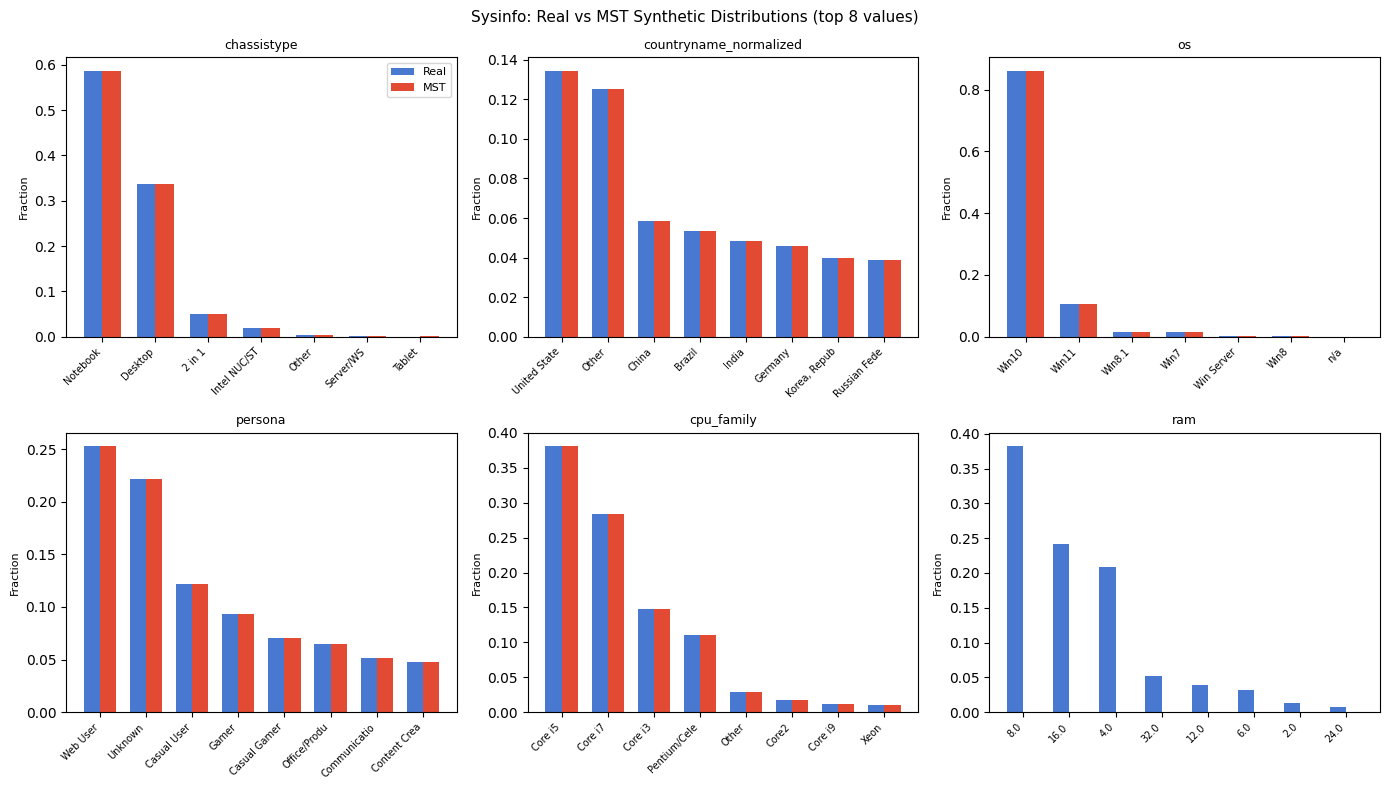

In [38]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8))
plot_cols = ["chassistype", "countryname_normalized", "os", "persona", "cpu_family", "ram"]

for ax, col in zip(axes.flat, plot_cols):
    real_counts = sysinfo[col].astype(str).value_counts(normalize=True).nlargest(8)
    synth_counts = sysinfo_synth[col].astype(str).value_counts(normalize=True)
    
    categories = real_counts.index.tolist()
    real_vals = [real_counts.get(c, 0) for c in categories]
    synth_vals = [synth_counts.get(c, 0) for c in categories]
    
    x = np.arange(len(categories))
    w = 0.35
    ax.bar(x - w/2, real_vals, w, color=REAL_COLOR, label="Real")
    ax.bar(x + w/2, synth_vals, w, color=SYNTH_COLOR, label="MST")
    ax.set_xticks(x)
    ax.set_xticklabels([c[:12] for c in categories], rotation=45, ha="right", fontsize=7)
    ax.set_title(col, fontsize=9)
    ax.set_ylabel("Fraction", fontsize=8)

axes[0, 0].legend(fontsize=8)
fig.suptitle("Sysinfo: Real vs MST Synthetic Distributions (top 8 values)", fontsize=11)
plt.tight_layout()
plt.show()

---
## Step 4: Synthesize per-table reporting tables

For each reporting table:
1. Aggregate to guid level (the grain most queries operate on)
2. Discretize continuous columns into quantile bins
3. Run MST with the per-table privacy budget
4. Reconstruct continuous values
5. Assign synthetic guids preserving the real join rate

Privacy budget: each table gets its own epsilon=4.0. Since queries touch at most a few tables, the effective privacy cost for any single query is at most the sum of the tables it references. Alternatively, this can be viewed as epsilon=4.0 per table under the "billboard model" where each table is independent.

In [39]:
def assign_synth_guids(synth_df, real_guid_count, total_real_guids, synth_guids, rng):
    join_rate = real_guid_count / total_real_guids
    n_synth_guids = max(1, int(join_rate * len(synth_guids)))
    chosen_guids = rng.choice(synth_guids, size=n_synth_guids, replace=False)

    n_rows = len(synth_df)
    if n_rows <= n_synth_guids:
        assigned = chosen_guids[:n_rows]
    else:
        assigned = rng.choice(chosen_guids, size=n_rows, replace=True)

    synth_df = synth_df.copy()
    synth_df.insert(0, "guid", assigned)
    return synth_df


display(Markdown("Guid assignment helper defined."))

Guid assignment helper defined.

In [40]:
display(Markdown("### Network consumption"))

net_raw = read_reporting("system_network_consumption")
net_agg = con.execute("""
    SELECT guid, input_desc,
           SUM(nrs) as nrs,
           SUM(nrs * avg_bytes_sec) / SUM(nrs) as avg_bytes_sec
    FROM read_parquet('{path}')
    GROUP BY guid, input_desc
""".format(path=REPORTING / "system_network_consumption.parquet")).df()

net_real_guids = net_agg["guid"].nunique()

if _MST_CACHED:
    net_synth_table = _MST_CACHE["system_network_consumption"]
    display(Markdown(f"Loaded cached: {len(net_synth_table):,} rows, {net_synth_table['guid'].nunique():,} guids (real: {net_real_guids:,})"))
    display(net_synth_table.head(3))
else:
    net_cat = ["input_desc"]
    net_num = ["nrs", "avg_bytes_sec"]
    net_synth_table, _ = synthesize_table_mst(
        net_agg, net_cat, net_num, EPSILON, DELTA, n_rows=len(net_agg)
    )
    net_synth_table = assign_synth_guids(
        net_synth_table, net_real_guids, len(all_guids), synth_guids, rng
    )
    net_synth_table["nrs"] = net_synth_table["nrs"].clip(lower=1)
    net_synth_table["avg_bytes_sec"] = net_synth_table["avg_bytes_sec"].clip(lower=0)

    display(Markdown(f"{len(net_synth_table):,} rows, {net_synth_table['guid'].nunique():,} guids (real: {net_real_guids:,})"))
    display(net_synth_table.head(3))

### Network consumption

74,448 rows, 32,121 guids (real: 37,224)

,guid,input_desc,nrs,avg_bytes_sec
0,synth_0032298,OS:NETWORK INTERFACE::BYTES RECEIVED/SEC::,3.627162e+06,14984.842014
1,synth_0330427,OS:NETWORK INTERFACE::BYTES RECEIVED/SEC::,1.639059e+06,35308.614600
2,synth_0158172,OS:NETWORK INTERFACE::BYTES RECEIVED/SEC::,2.085152e+05,42974.882126


In [41]:
display(Markdown("### Memory utilization"))

mem_agg = con.execute("""
    SELECT guid,
           SUM(nrs) as nrs,
           SUM(nrs * avg_percentage_used) / SUM(nrs) as avg_percentage_used,
           MAX(sysinfo_ram) as sysinfo_ram
    FROM read_parquet('{path}')
    WHERE avg_percentage_used > 0
    GROUP BY guid
""".format(path=REPORTING / "system_memory_utilization.parquet")).df()

mem_real_guids = mem_agg["guid"].nunique()

if _MST_CACHED:
    mem_synth_table = _MST_CACHE["system_memory_utilization"]
    display(Markdown(f"Loaded cached: {len(mem_synth_table):,} rows, {mem_synth_table['guid'].nunique():,} guids (real: {mem_real_guids:,})"))
    display(mem_synth_table.head(3))
else:
    mem_cat = []
    mem_num = ["nrs", "avg_percentage_used", "sysinfo_ram"]
    mem_synth_table, _ = synthesize_table_mst(
        mem_agg, mem_cat, mem_num, EPSILON, DELTA, n_rows=len(mem_agg)
    )
    mem_synth_table = assign_synth_guids(
        mem_synth_table, mem_real_guids, len(all_guids), synth_guids, rng
    )
    mem_synth_table["nrs"] = mem_synth_table["nrs"].clip(lower=1)
    mem_synth_table["avg_percentage_used"] = mem_synth_table["avg_percentage_used"].clip(0, 100)
    mem_synth_table["sysinfo_ram"] = mem_synth_table["sysinfo_ram"].clip(lower=1024)

    display(Markdown(f"{len(mem_synth_table):,} rows, {mem_synth_table['guid'].nunique():,} guids (real: {mem_real_guids:,})"))
    display(mem_synth_table.head(3))

### Memory utilization

69,497 rows, 69,497 guids (real: 69,497)

,guid,nrs,avg_percentage_used,sysinfo_ram
0,synth_0929953,127759.461369,50.654605,6790.269914
1,synth_0679478,8269.750050,50.489689,7139.825673
2,synth_0115056,293127.532332,58.113823,6401.838384


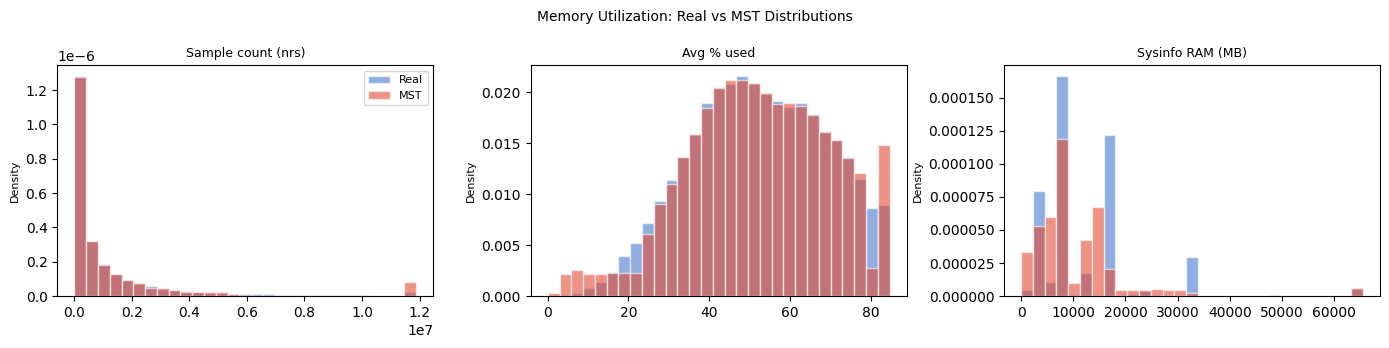

In [42]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3.5))

for ax, col, title in zip(axes, ["nrs", "avg_percentage_used", "sysinfo_ram"],
                           ["Sample count (nrs)", "Avg % used", "Sysinfo RAM (MB)"]):
    real_vals = mem_agg[col].clip(upper=mem_agg[col].quantile(0.99))
    synth_vals = mem_synth_table[col].clip(upper=mem_agg[col].quantile(0.99))
    bins = np.linspace(0, real_vals.max(), 30)
    ax.hist(real_vals, bins=bins, alpha=0.6, color=REAL_COLOR, label="Real", density=True, edgecolor="white")
    ax.hist(synth_vals, bins=bins, alpha=0.6, color=SYNTH_COLOR, label="MST", density=True, edgecolor="white")
    ax.set_title(title, fontsize=9)
    ax.set_ylabel("Density", fontsize=8)

axes[0].legend(fontsize=8)
fig.suptitle("Memory Utilization: Real vs MST Distributions", fontsize=10)
plt.tight_layout()
plt.show()

In [43]:
display(Markdown("### Hardware metric tables (psys_rap, pkg_C0, avg_freq, temp, hw_pkg_power)"))

hw_tables = {
    "system_psys_rap_watts": {"num": ["nrs", "avg_psys_rap_watts"]},
    "system_pkg_C0": {"num": ["nrs", "avg_pkg_c0"]},
    "system_pkg_avg_freq_mhz": {"num": ["nrs", "avg_avg_freq_mhz"]},
    "system_pkg_temp_centigrade": {"num": ["nrs", "avg_temp_centigrade"]},
    "system_hw_pkg_power": {"num": ["nrs", "mean"]},
}

hw_synth_tables = {}
hw_summary_rows = []

if _MST_CACHED:
    for table_name in hw_tables:
        hw_synth_tables[table_name] = _MST_CACHE[table_name]
        raw = read_reporting(table_name)
        real_g = raw["guid"].nunique()
        hw_summary_rows.append({
            "table": table_name,
            "real_rows": len(raw.groupby("guid").first()),
            "real_guids": real_g,
            "synth_rows": len(hw_synth_tables[table_name]),
            "synth_guids": hw_synth_tables[table_name]["guid"].nunique(),
        })
    display(Markdown("Loaded cached hardware metric tables."))
    display(pd.DataFrame(hw_summary_rows))
else:
    for table_name, spec in hw_tables.items():
        raw = read_reporting(table_name)
        num_cols = spec["num"]

        agg_cols = ", ".join(
            ["guid"] +
            [f"SUM(nrs) as nrs"] +
            [f"SUM(nrs * {c}) / SUM(nrs) as {c}" for c in num_cols if c != "nrs"]
        )
        agg = con.execute(f"""
            SELECT {agg_cols}
            FROM read_parquet('{REPORTING / table_name}.parquet')
            GROUP BY guid
        """).df()

        real_g = agg["guid"].nunique()

        synth_t, _ = synthesize_table_mst(
            agg, [], num_cols, EPSILON, DELTA, n_rows=len(agg)
        )
        synth_t = assign_synth_guids(synth_t, real_g, len(all_guids), synth_guids, rng)
        synth_t["nrs"] = synth_t["nrs"].clip(lower=1)
        for c in num_cols:
            if c != "nrs":
                synth_t[c] = synth_t[c].clip(lower=0)

        hw_synth_tables[table_name] = synth_t
        hw_summary_rows.append({
            "table": table_name,
            "real_rows": len(agg),
            "real_guids": real_g,
            "synth_rows": len(synth_t),
            "synth_guids": synth_t["guid"].nunique(),
        })

    display(pd.DataFrame(hw_summary_rows))

### Hardware metric tables (psys_rap, pkg_C0, avg_freq, temp, hw_pkg_power)

,table,real_rows,real_guids,synth_rows,synth_guids
0,system_psys_rap_watts,611,611,611,611
1,system_pkg_C0,8943,8943,8943,8943
2,system_pkg_avg_freq_mhz,613,613,613,613
3,system_pkg_temp_centigrade,622,622,622,622
4,system_hw_pkg_power,800,800,800,800


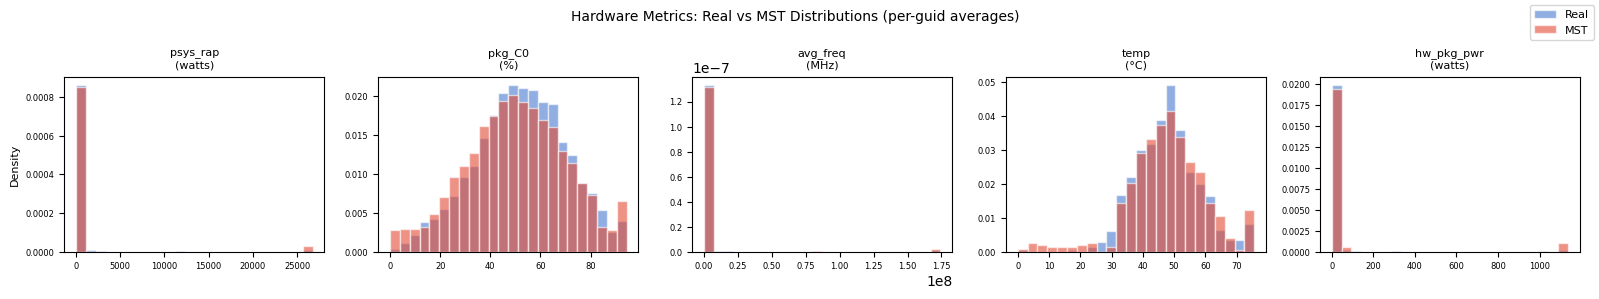

In [44]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3))
hw_labels = ["psys_rap\n(watts)", "pkg_C0\n(%)", "avg_freq\n(MHz)", "temp\n(°C)", "hw_pkg_pwr\n(watts)"]
hw_metric_cols = ["avg_psys_rap_watts", "avg_pkg_c0", "avg_avg_freq_mhz", "avg_temp_centigrade", "mean"]

for ax, (table_name, spec), label, mcol in zip(axes, hw_tables.items(), hw_labels, hw_metric_cols):
    real_t = read_reporting(table_name)
    real_agg = real_t.groupby("guid")[mcol].mean()
    synth_t = hw_synth_tables[table_name]
    synth_agg = synth_t.groupby("guid")[mcol].mean()
    
    upper = real_agg.quantile(0.99)
    bins = np.linspace(0, upper, 25)
    ax.hist(real_agg.clip(upper=upper), bins=bins, alpha=0.6, color=REAL_COLOR, density=True, edgecolor="white")
    ax.hist(synth_agg.clip(upper=upper), bins=bins, alpha=0.6, color=SYNTH_COLOR, density=True, edgecolor="white")
    ax.set_title(label, fontsize=8)
    ax.tick_params(labelsize=6)

axes[0].set_ylabel("Density", fontsize=8)
fig.legend(["Real", "MST"], loc="upper right", fontsize=8)
fig.suptitle("Hardware Metrics: Real vs MST Distributions (per-guid averages)", fontsize=10)
plt.tight_layout()
plt.show()

In [45]:
display(Markdown("### Battery DC events"))

batt_agg = con.execute("""
    SELECT guid,
           SUM(duration_mins) as duration_mins,
           SUM(num_power_ons) as num_power_ons
    FROM read_parquet('{path}')
    GROUP BY guid
""".format(path=REPORTING / "system_batt_dc_events.parquet")).df()

batt_real_guids = batt_agg["guid"].nunique()

if _MST_CACHED:
    batt_synth = _MST_CACHE["system_batt_dc_events"]
    display(Markdown(f"Loaded cached: {len(batt_synth):,} rows, {batt_synth['guid'].nunique():,} guids (real: {batt_real_guids:,})"))
    display(batt_synth.head(3))
else:
    batt_synth, _ = synthesize_table_mst(
        batt_agg, [], ["duration_mins", "num_power_ons"], EPSILON, DELTA, n_rows=len(batt_agg)
    )
    batt_synth = assign_synth_guids(batt_synth, batt_real_guids, len(all_guids), synth_guids, rng)
    batt_synth["duration_mins"] = batt_synth["duration_mins"].clip(lower=0)
    batt_synth["num_power_ons"] = batt_synth["num_power_ons"].clip(lower=0).round().astype(int)

    display(Markdown(f"{len(batt_synth):,} rows, {batt_synth['guid'].nunique():,} guids (real: {batt_real_guids:,})"))
    display(batt_synth.head(3))

### Battery DC events

19,780 rows, 19,780 guids (real: 19,780)

,guid,duration_mins,num_power_ons
0,synth_0757294,7140.740781,54
1,synth_0140377,128.246065,2
2,synth_0174775,68.297517,8


In [46]:
display(Markdown("### Web category usage (browser-level)"))

web_agg = con.execute("""
    SELECT guid, browser,
           SUM(duration_ms) as duration_ms,
           SUM(page_load_count) as page_load_count
    FROM read_parquet('{path}')
    GROUP BY guid, browser
""".format(path=REPORTING / "system_web_cat_usage.parquet")).df()

web_real_guids = web_agg["guid"].nunique()

if _MST_CACHED:
    web_synth = _MST_CACHE["system_web_cat_usage"]
    display(Markdown(f"Loaded cached: {len(web_synth):,} rows, {web_synth['guid'].nunique():,} guids (real: {web_real_guids:,})"))
    display(web_synth.head(3))
else:
    web_synth, _ = synthesize_table_mst(
        web_agg, ["browser"], ["duration_ms", "page_load_count"], EPSILON, DELTA, n_rows=len(web_agg)
    )
    web_synth = assign_synth_guids(web_synth, web_real_guids, len(all_guids), synth_guids, rng)
    web_synth["duration_ms"] = web_synth["duration_ms"].clip(lower=0)
    web_synth["page_load_count"] = web_synth["page_load_count"].clip(lower=0).round().astype(int)

    display(Markdown(f"{len(web_synth):,} rows, {web_synth['guid'].nunique():,} guids (real: {web_real_guids:,})"))
    display(web_synth.head(3))

### Web category usage (browser-level)

99,995 rows, 50,617 guids (real: 64,276)

,guid,browser,duration_ms,page_load_count
0,synth_0643063,edge,2.364120e+06,2
1,synth_0633510,chrome,2.358880e+07,343
2,synth_0106718,edge,5.011048e+03,2


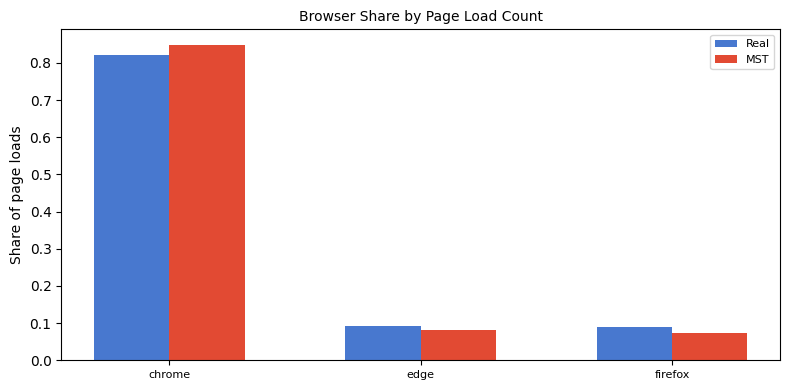

In [47]:
fig, ax = plt.subplots(figsize=(8, 4))

real_browser = web_agg.groupby("browser")["page_load_count"].sum()
real_browser = (real_browser / real_browser.sum()).nlargest(6)
synth_browser = web_synth.groupby("browser")["page_load_count"].sum()
synth_browser = synth_browser / synth_browser.sum()

browsers_list = real_browser.index.tolist()
x = np.arange(len(browsers_list))
w = 0.3
ax.bar(x - w/2, [real_browser.get(b, 0) for b in browsers_list], w, color=REAL_COLOR, label="Real")
ax.bar(x + w/2, [synth_browser.get(b, 0) for b in browsers_list], w, color=SYNTH_COLOR, label="MST")
ax.set_xticks(x)
ax.set_xticklabels(browsers_list, fontsize=8)
ax.set_ylabel("Share of page loads")
ax.set_title("Browser Share by Page Load Count", fontsize=10)
ax.legend(fontsize=8)
plt.tight_layout()
plt.show()

In [48]:
display(Markdown("### Web category pivot (per-guid duration by 28 categories)"))

pivot_raw = read_reporting("system_web_cat_pivot_duration")
cat_duration_cols = [c for c in pivot_raw.columns if c not in ("guid", "dt")]
pivot_real_guids = pivot_raw["guid"].nunique()

if _MST_CACHED:
    pivot_synth = _MST_CACHE["system_web_cat_pivot_duration"]
    display(Markdown(
        f"Loaded cached: {len(pivot_synth):,} rows from {pivot_synth['guid'].nunique():,} guids "
        f"(real: {len(pivot_raw):,} rows, {pivot_real_guids:,} guids)"
    ))
    display(pivot_synth.head(3))
else:
    days_per_guid = pivot_raw.groupby("guid").size()
    days_distribution = days_per_guid.values

    pivot_agg = con.execute("""
        SELECT guid, {agg}
        FROM read_parquet('{path}')
        GROUP BY guid
    """.format(
        agg=", ".join(f"SUM(\"{c}\") as \"{c}\"" for c in cat_duration_cols),
        path=REPORTING / "system_web_cat_pivot_duration.parquet"
    )).df()

    pivot_synth_agg, _ = synthesize_table_mst(
        pivot_agg, [], cat_duration_cols, EPSILON, DELTA, n_rows=len(pivot_agg)
    )
    pivot_synth_agg = assign_synth_guids(pivot_synth_agg, pivot_real_guids, len(all_guids), synth_guids, rng)
    for c in cat_duration_cols:
        pivot_synth_agg[c] = pivot_synth_agg[c].clip(lower=0)

    n_days_per_row = rng.choice(days_distribution, size=len(pivot_synth_agg)).clip(min=1)
    pivot_synth_agg["_n_days"] = n_days_per_row

    repeat_idx = np.repeat(np.arange(len(pivot_synth_agg)), n_days_per_row)
    pivot_synth = pivot_synth_agg.iloc[repeat_idx].reset_index(drop=True)

    for c in cat_duration_cols:
        pivot_synth[c] = pivot_synth[c] / pivot_synth["_n_days"]

    pivot_synth["dt"] = pd.Timestamp("2024-01-01")
    pivot_synth = pivot_synth.drop(columns=["_n_days"])

    display(Markdown(
        f"{len(pivot_synth):,} rows from {pivot_synth['guid'].nunique():,} guids "
        f"(real: {len(pivot_raw):,} rows, {pivot_real_guids:,} guids)"
    ))
    display(pivot_synth.head(3))

### Web category pivot (per-guid duration by 28 categories)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

4,541,450 rows from 64,276 guids (real: 4,537,100 rows, 64,276 guids)

,guid,content_creation_photo_edit_creation,content_creation_video_audio_edit_creation,content_creation_web_design_development,education,entertainment_music_audio_streaming,entertainment_other,entertainment_video_streaming,finance,games_other,...,productivity_spreadsheets,productivity_word_processing,recreation_travel,reference,search,shopping,social_social_network,social_communication,social_communication_live,dt
0,synth_0514003,7.056563e+01,7398.977842,5.143017e+02,371.134684,1337.494917,8316.108812,1.503663e+07,5363.86492,1.872384e+02,...,32261.122944,20345.105324,5995.228681,2641.096606,1.793998e+04,1.048769e+03,3.837021e+01,1663.987108,1531.643101,2024-01-01
1,synth_0514003,7.056563e+01,7398.977842,5.143017e+02,371.134684,1337.494917,8316.108812,1.503663e+07,5363.86492,1.872384e+02,...,32261.122944,20345.105324,5995.228681,2641.096606,1.793998e+04,1.048769e+03,3.837021e+01,1663.987108,1531.643101,2024-01-01
2,synth_0600023,4.456261e+08,725.818543,1.214242e+09,426806.485425,486.322571,84002.887127,2.141922e+09,6646.24263,1.546277e+09,...,155431.676343,7055.556337,107199.048973,984863.266259,2.186202e+07,3.286850e+06,1.362352e+06,56120.603311,10448.743453,2024-01-01


In [49]:
display(Markdown("### On/off/suspend time"))

onoff_agg = con.execute("""
    SELECT guid,
           SUM(on_time) as on_time,
           SUM(off_time) as off_time,
           SUM(mods_time) as mods_time,
           SUM(sleep_time) as sleep_time
    FROM read_parquet('{path}')
    GROUP BY guid
""".format(path=REPORTING / "system_on_off_suspend_time_day.parquet")).df()

onoff_real_guids = onoff_agg["guid"].nunique()

if _MST_CACHED:
    onoff_synth = _MST_CACHE["system_on_off_suspend_time_day"]
    display(Markdown(f"Loaded cached: {len(onoff_synth):,} rows, {onoff_synth['guid'].nunique():,} guids (real: {onoff_real_guids:,})"))
    display(onoff_synth.head(3))
else:
    onoff_synth, _ = synthesize_table_mst(
        onoff_agg, [], ["on_time", "off_time", "mods_time", "sleep_time"], EPSILON, DELTA, n_rows=len(onoff_agg)
    )
    onoff_synth = assign_synth_guids(onoff_synth, onoff_real_guids, len(all_guids), synth_guids, rng)
    for c in ["on_time", "off_time", "mods_time", "sleep_time"]:
        onoff_synth[c] = onoff_synth[c].clip(lower=0)

    display(Markdown(f"{len(onoff_synth):,} rows, {onoff_synth['guid'].nunique():,} guids (real: {onoff_real_guids:,})"))
    display(onoff_synth.head(3))

### On/off/suspend time

36,958 rows, 36,958 guids (real: 36,958)

,guid,on_time,off_time,mods_time,sleep_time
0,synth_0036786,271017.775460,30962.959807,3301.485999,6.004465e+06
1,synth_0047797,728031.809498,16.057857,1433.473129,3.285544e+05
2,synth_0046176,314927.411976,5.000407,2713.962613,3.521689e+06


In [50]:
display(Markdown("### Display devices"))

disp_agg = con.execute("""
    SELECT guid, connection_type, vendor_name,
           AVG(resolution_width) as resolution_width,
           AVG(resolution_heigth) as resolution_heigth,
           SUM(duration_ac) as duration_ac,
           SUM(duration_dc) as duration_dc
    FROM read_parquet('{path}')
    GROUP BY guid, connection_type, vendor_name
""".format(path=REPORTING / "system_display_devices.parquet")).df()

disp_real_guids = disp_agg["guid"].nunique()

if _MST_CACHED:
    disp_synth = _MST_CACHE["system_display_devices"]
    display(Markdown(f"Loaded cached: {len(disp_synth):,} rows, {disp_synth['guid'].nunique():,} guids (real: {disp_real_guids:,})"))
    display(disp_synth.head(3))
else:
    disp_synth, _ = synthesize_table_mst(
        disp_agg,
        ["connection_type", "vendor_name"],
        ["resolution_width", "resolution_heigth", "duration_ac", "duration_dc"],
        EPSILON, DELTA, n_rows=len(disp_agg)
    )
    disp_synth = assign_synth_guids(disp_synth, disp_real_guids, len(all_guids), synth_guids, rng)
    for c in ["resolution_width", "resolution_heigth"]:
        disp_synth[c] = disp_synth[c].clip(lower=0).round().astype(int)
    for c in ["duration_ac", "duration_dc"]:
        disp_synth[c] = disp_synth[c].clip(lower=0)

    display(Markdown(f"{len(disp_synth):,} rows, {disp_synth['guid'].nunique():,} guids (real: {disp_real_guids:,})"))
    display(disp_synth.head(3))

### Display devices

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

589,719 rows, 196,784 guids (real: 209,239)

,guid,connection_type,vendor_name,resolution_width,resolution_heigth,duration_ac,duration_dc
0,synth_0381843,HDMI,Other,1914,1080,1.308588e+04,1.148726e+04
1,synth_0263490,OTHER,Other,298,144,1.852550e+06,2.232283e+00
2,synth_0178761,HDMI,LG,1056,727,1.039892e+06,2.467071e+06


In [51]:
display(Markdown("### User wait"))

uw_agg = con.execute("""
    SELECT guid, event_name, acdc, proc_name,
           SUM(number_of_instances) as number_of_instances,
           SUM(total_duration_ms) as total_duration_ms
    FROM read_parquet('{path}')
    GROUP BY guid, event_name, acdc, proc_name
""".format(path=REPORTING / "system_userwait.parquet")).df()

uw_real_guids = uw_agg["guid"].nunique()

if _MST_CACHED:
    uw_synth = _MST_CACHE["system_userwait"]
    display(Markdown(f"Loaded cached: {len(uw_synth):,} rows, {uw_synth['guid'].nunique():,} guids (real: {uw_real_guids:,})"))
    display(uw_synth.head(3))
else:
    uw_top_procs = uw_agg.groupby("proc_name")["total_duration_ms"].sum().nlargest(100).index.tolist()
    uw_filtered = uw_agg[uw_agg["proc_name"].isin(uw_top_procs)].copy()

    uw_synth, _ = synthesize_table_mst(
        uw_filtered,
        ["event_name", "acdc", "proc_name"],
        ["number_of_instances", "total_duration_ms"],
        EPSILON, DELTA, n_rows=len(uw_filtered)
    )
    uw_synth = assign_synth_guids(uw_synth, uw_real_guids, len(all_guids), synth_guids, rng)
    uw_synth["number_of_instances"] = uw_synth["number_of_instances"].clip(lower=1).round().astype(int)
    uw_synth["total_duration_ms"] = uw_synth["total_duration_ms"].clip(lower=0)

    display(Markdown(f"{len(uw_synth):,} rows, {uw_synth['guid'].nunique():,} guids (real: {uw_real_guids:,})"))
    display(uw_synth.head(3))

### User wait

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,757,095 rows, 38,142 guids (real: 38,142)

,guid,event_name,acdc,proc_name,number_of_instances,total_duration_ms
0,synth_0258995,APPSTARTING,DC,chrome.exe,2,8.387187e+03
1,synth_0117281,APPSTARTING,AC,RESTRICTED PROCESS,8,3.237948e+04
2,synth_0054007,APPSTARTING,DC,DESKTOP,1173911,1.134622e+06


In [52]:
display(Markdown("### Foreground apps"))

frgnd_agg = con.execute("""
    SELECT guid, app_type, exe_name,
           SUM(totalsecfocal_day) as totalsecfocal_day,
           SUM(lines_per_day) as lines_per_day
    FROM read_parquet('{path}')
    GROUP BY guid, app_type, exe_name
""".format(path=REPORTING / "system_frgnd_apps_types.parquet")).df()

frgnd_real_guids = frgnd_agg["guid"].nunique()

if _MST_CACHED:
    frgnd_synth = _MST_CACHE["system_frgnd_apps_types"]
    display(Markdown(f"Loaded cached: {len(frgnd_synth):,} rows, {frgnd_synth['guid'].nunique():,} guids (real: {frgnd_real_guids:,})"))
    display(frgnd_synth.head(3))
else:
    frgnd_top_apps = frgnd_agg.groupby("exe_name")["totalsecfocal_day"].sum().nlargest(200).index.tolist()
    frgnd_filtered = frgnd_agg[frgnd_agg["exe_name"].isin(frgnd_top_apps)].copy()

    frgnd_synth, _ = synthesize_table_mst(
        frgnd_filtered,
        ["app_type", "exe_name"],
        ["totalsecfocal_day", "lines_per_day"],
        EPSILON, DELTA, n_rows=len(frgnd_filtered)
    )
    frgnd_synth = assign_synth_guids(frgnd_synth, frgnd_real_guids, len(all_guids), synth_guids, rng)
    frgnd_synth["totalsecfocal_day"] = frgnd_synth["totalsecfocal_day"].clip(lower=0)
    frgnd_synth["lines_per_day"] = frgnd_synth["lines_per_day"].clip(lower=0).round().astype(int)

    display(Markdown(f"{len(frgnd_synth):,} rows, {frgnd_synth['guid'].nunique():,} guids (real: {frgnd_real_guids:,})"))
    display(frgnd_synth.head(3))

### Foreground apps

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

1,239,878 rows, 55,830 guids (real: 55,830)

,guid,app_type,exe_name,totalsecfocal_day,lines_per_day
0,synth_0328638,System,explorer.exe,264597.179032,35
1,synth_0298617,Gaming auxiliary,battle.net.exe,43.253513,21
2,synth_0115963,Productivity,acrord32.exe,3.738618,1


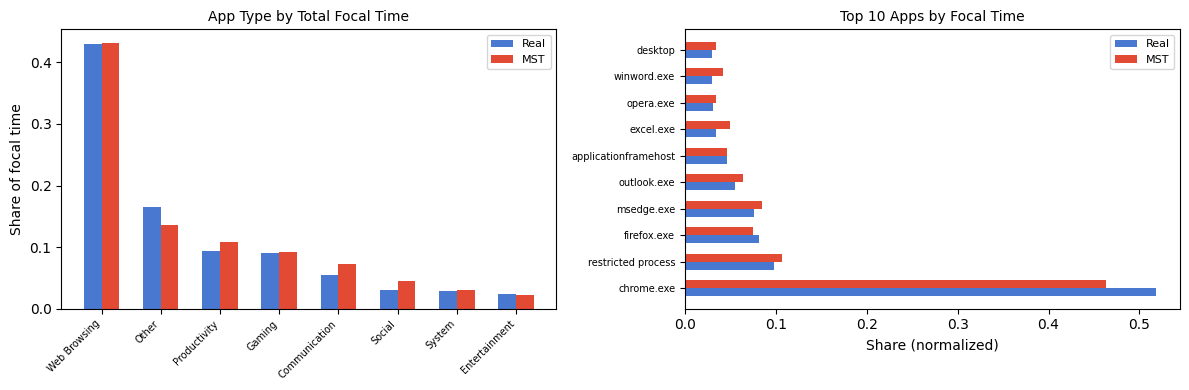

In [53]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

real_types = frgnd_agg.groupby("app_type")["totalsecfocal_day"].sum()
real_types = (real_types / real_types.sum()).nlargest(8)
synth_types = frgnd_synth.groupby("app_type")["totalsecfocal_day"].sum()
synth_types = synth_types / synth_types.sum()

types_list = real_types.index.tolist()
x = np.arange(len(types_list))
w = 0.3
axes[0].bar(x - w/2, [real_types.get(t, 0) for t in types_list], w, color=REAL_COLOR, label="Real")
axes[0].bar(x + w/2, [synth_types.get(t, 0) for t in types_list], w, color=SYNTH_COLOR, label="MST")
axes[0].set_xticks(x)
axes[0].set_xticklabels(types_list, rotation=45, ha="right", fontsize=7)
axes[0].set_ylabel("Share of focal time")
axes[0].set_title("App Type by Total Focal Time", fontsize=10)
axes[0].legend(fontsize=8)

real_top = frgnd_agg.groupby("exe_name")["totalsecfocal_day"].sum().nlargest(10)
synth_top = frgnd_synth.groupby("exe_name")["totalsecfocal_day"].sum()
apps = real_top.index.tolist()
y = np.arange(len(apps))
h = 0.3

real_norm = real_top.values / real_top.values.sum()
synth_norm = np.array([synth_top.get(a, 0) for a in apps])
synth_norm = synth_norm / max(synth_norm.sum(), 1e-10)

axes[1].barh(y - h/2, real_norm, h, color=REAL_COLOR, label="Real")
axes[1].barh(y + h/2, synth_norm, h, color=SYNTH_COLOR, label="MST")
axes[1].set_yticks(y)
axes[1].set_yticklabels([a[:20] for a in apps], fontsize=7)
axes[1].set_xlabel("Share (normalized)")
axes[1].set_title("Top 10 Apps by Focal Time", fontsize=10)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [54]:
display(Markdown("### Mods top blocker hist"))

block_agg = con.execute("""
    SELECT guid, blocker_name, blocker_type, activity_level,
           SUM(active_time_ms) as active_time_ms,
           COUNT(*) as n_entries
    FROM read_parquet('{path}')
    GROUP BY guid, blocker_name, blocker_type, activity_level
""".format(path=REPORTING / "system_mods_top_blocker_hist.parquet")).df()

block_real_guids = block_agg["guid"].nunique()

if _MST_CACHED:
    block_synth = _MST_CACHE["system_mods_top_blocker_hist"]
    display(Markdown(f"Loaded cached: {len(block_synth):,} rows, {block_synth['guid'].nunique():,} guids (real: {block_real_guids:,})"))
    display(block_synth.head(3))
else:
    block_top = block_agg.groupby("blocker_name")["active_time_ms"].sum().nlargest(100).index.tolist()
    block_filtered = block_agg[block_agg["blocker_name"].isin(block_top)].copy()

    block_cat = ["blocker_name", "blocker_type"]
    if block_filtered["activity_level"].nunique() <= 50:
        block_filtered["activity_level"] = block_filtered["activity_level"].astype(str).fillna("__null__")
        block_cat.append("activity_level")

    block_synth, _ = synthesize_table_mst(
        block_filtered,
        block_cat,
        ["active_time_ms"],
        EPSILON, DELTA, n_rows=len(block_filtered)
    )
    block_synth = assign_synth_guids(block_synth, block_real_guids, len(all_guids), synth_guids, rng)
    block_synth["active_time_ms"] = block_synth["active_time_ms"].clip(lower=0)

    block_synth["dt"] = pd.Timestamp("2024-06-15")

    display(Markdown(f"{len(block_synth):,} rows, {block_synth['guid'].nunique():,} guids (real: {block_real_guids:,})"))
    display(block_synth.head(3))

### Mods top blocker hist

861,034 rows, 65,033 guids (real: 65,034)

,guid,blocker_name,blocker_type,activity_level,active_time_ms,dt
0,synth_0823713,Intel(R) PCI Express Root Port #5 - 02BC (\_SB...,Fx Device,moderate,5.931654e+06,2024-06-15
1,synth_0321373,WU,Activator,high,1.232219e+06,2024-06-15
2,synth_0597083,Maintenance Phase,PDC Phase,low,1.269518e+03,2024-06-15


In [55]:
display(Markdown("### CPU metadata"))

cpu_meta = read_reporting("system_cpu_metadata")
cpu_meta_cols_cat = ["cpucode", "processtechnology", "marketcodename", "cpugen"]
cpu_meta_cols_num = ["#ofcores", "spec_tdp"]
cpu_real_guids = cpu_meta["guid"].nunique()

if _MST_CACHED:
    cpu_synth = _MST_CACHE["system_cpu_metadata"]
    display(Markdown(f"Loaded cached: {len(cpu_synth):,} rows, {cpu_synth['guid'].nunique():,} guids (real: {cpu_real_guids:,})"))
    display(cpu_synth.head(3))
else:
    cpu_work = cpu_meta[cpu_meta_cols_cat + cpu_meta_cols_num].copy()

    for c in cpu_meta_cols_num:
        cpu_work[c] = pd.to_numeric(cpu_work[c], errors="coerce").fillna(0)

    cpu_topk_maps = {}
    for c in cpu_meta_cols_cat:
        cpu_work[c] = cpu_work[c].astype(str).fillna("__null__")
        if cpu_work[c].nunique() > MAX_CARDINALITY:
            top_vals = cpu_work[c].value_counts().nlargest(MAX_CARDINALITY).index.tolist()
            cpu_topk_maps[c] = top_vals
            cpu_work[c] = cpu_work[c].where(cpu_work[c].isin(top_vals), "__other__")

    cpu_synth, _ = synthesize_table_mst(
        cpu_work, cpu_meta_cols_cat, cpu_meta_cols_num, EPSILON, DELTA, n_rows=len(cpu_work)
    )

    for c, top_vals in cpu_topk_maps.items():
        other_mask = cpu_synth[c] == "__other__"
        if other_mask.any():
            real_other = cpu_meta[c].astype(str)[~cpu_meta[c].astype(str).isin(top_vals)]
            if len(real_other) > 0:
                cpu_synth.loc[other_mask, c] = rng.choice(real_other.values, size=other_mask.sum(), replace=True)

    cpu_synth = assign_synth_guids(cpu_synth, cpu_real_guids, len(all_guids), synth_guids, rng)
    cpu_synth["#ofcores"] = cpu_synth["#ofcores"].clip(lower=1).round().astype(int)
    cpu_synth["spec_tdp"] = cpu_synth["spec_tdp"].clip(lower=0)

    cpu_synth["cpu"] = cpu_synth["cpucode"]
    cpu_synth["lithography"] = np.nan
    cpu_synth["marketsegment"] = np.nan
    cpu_synth["launchdate"] = np.nan
    cpu_synth["estfirstusedt"] = np.nan

    display(Markdown(f"{len(cpu_synth):,} rows, {cpu_synth['guid'].nunique():,} guids (real: {cpu_real_guids:,})"))
    display(cpu_synth.head(3))

### CPU metadata

1,000,000 rows, 1,000,000 guids (real: 1,000,000)

,guid,cpucode,processtechnology,marketcodename,cpugen,#ofcores,spec_tdp,cpu,lithography,marketsegment,launchdate,estfirstusedt
0,synth_0367155,i5-4460,1270,Haswell,4th Gen i5,4,40.283758,i5-4460,NaN,NaN,NaN,NaN
1,synth_0518306,i5-430M,1270,Ivy Bridge,3rd Gen i7,4,75.301167,i5-430M,NaN,NaN,NaN,NaN
2,synth_0587973,i7-6560U,1272,Coffee Lake,9th Gen i5,4,94.126684,i7-6560U,NaN,NaN,NaN,NaN


In [56]:
display(Markdown("### OS codename history"))

os_code = read_reporting("system_os_codename_history")
os_cat = ["os_name", "os_codename"]
os_real_guids = os_code["guid"].nunique()

if _MST_CACHED:
    os_synth = _MST_CACHE["system_os_codename_history"]
    display(Markdown(f"Loaded cached: {len(os_synth):,} rows, {os_synth['guid'].nunique():,} guids (real: {os_real_guids:,})"))
    display(os_synth.head(3))
else:
    os_work = os_code[["guid"] + os_cat].drop_duplicates(subset=["guid", "os_name", "os_codename"])

    os_synth_model = MSTSynthesizer(epsilon=EPSILON, delta=DELTA)
    os_work_fit = os_work[os_cat].copy()
    for c in os_cat:
        os_work_fit[c] = os_work_fit[c].astype(str).fillna("__null__")
    os_synth_model.fit(os_work_fit, categorical_columns=os_cat)
    os_synth_data = os_synth_model.sample(len(os_work))
    os_synth = pd.DataFrame(os_synth_data, columns=os_cat)
    os_synth.replace("__null__", np.nan, inplace=True)
    os_synth = assign_synth_guids(os_synth, os_real_guids, len(all_guids), synth_guids, rng)

    os_synth["load_ts"] = np.nan
    os_synth["min_ts"] = pd.Timestamp("2024-01-01")
    os_synth["max_ts"] = pd.Timestamp("2024-12-31")

    display(Markdown(f"{len(os_synth):,} rows, {os_synth['guid'].nunique():,} guids (real: {os_real_guids:,})"))
    display(os_synth.head(3))

### OS codename history

630,087 rows, 262,591 guids (real: 299,099)

,guid,os_name,os_codename,load_ts,min_ts,max_ts
0,synth_0455491,Win10,20H2,NaN,2024-01-01,2024-12-31
1,synth_0037241,Win10,21H1,NaN,2024-01-01,2024-12-31
2,synth_0805976,Win10,20H1,NaN,2024-01-01,2024-12-31


---
## Step 5: Save synthetic reporting tables

In [57]:
MST_REPORTING.mkdir(parents=True, exist_ok=True)

save_map = {
    "system_sysinfo_unique_normalized": sysinfo_synth,
    "system_network_consumption": net_synth_table,
    "system_memory_utilization": mem_synth_table,
    "system_psys_rap_watts": hw_synth_tables["system_psys_rap_watts"],
    "system_pkg_C0": hw_synth_tables["system_pkg_C0"],
    "system_pkg_avg_freq_mhz": hw_synth_tables["system_pkg_avg_freq_mhz"],
    "system_pkg_temp_centigrade": hw_synth_tables["system_pkg_temp_centigrade"],
    "system_hw_pkg_power": hw_synth_tables["system_hw_pkg_power"],
    "system_batt_dc_events": batt_synth,
    "system_web_cat_usage": web_synth,
    "system_web_cat_pivot_duration": pivot_synth,
    "system_on_off_suspend_time_day": onoff_synth,
    "system_display_devices": disp_synth,
    "system_userwait": uw_synth,
    "system_frgnd_apps_types": frgnd_synth,
    "system_mods_top_blocker_hist": block_synth,
    "system_cpu_metadata": cpu_synth,
    "system_os_codename_history": os_synth,
}

summary_rows = []
for name, df in save_map.items():
    path = MST_REPORTING / f"{name}.parquet"
    df.to_parquet(path, index=False)
    summary_rows.append({
        "table": name.replace("system_", ""),
        "rows": f"{len(df):,}",
        "guids": f"{df['guid'].nunique():,}",
        "columns": len(df.columns),
    })

display(Markdown(f"Saved {len(save_map)} synthetic tables to `{MST_REPORTING}`"))
display(pd.DataFrame(summary_rows))

Saved 18 synthetic tables to `../data/reporting/synth_mst`

,table,rows,guids,columns
0,sysinfo_unique_normalized,"1,000,000","1,000,000",32
1,network_consumption,"74,448","32,121",4
2,memory_utilization,"69,497","69,497",4
3,psys_rap_watts,611,611,3
4,pkg_C0,"8,943","8,943",3
5,pkg_avg_freq_mhz,613,613,3
6,pkg_temp_centigrade,622,622,3
7,hw_pkg_power,800,800,3
8,batt_dc_events,"19,780","19,780",3
9,web_cat_usage,"99,995","50,617",4


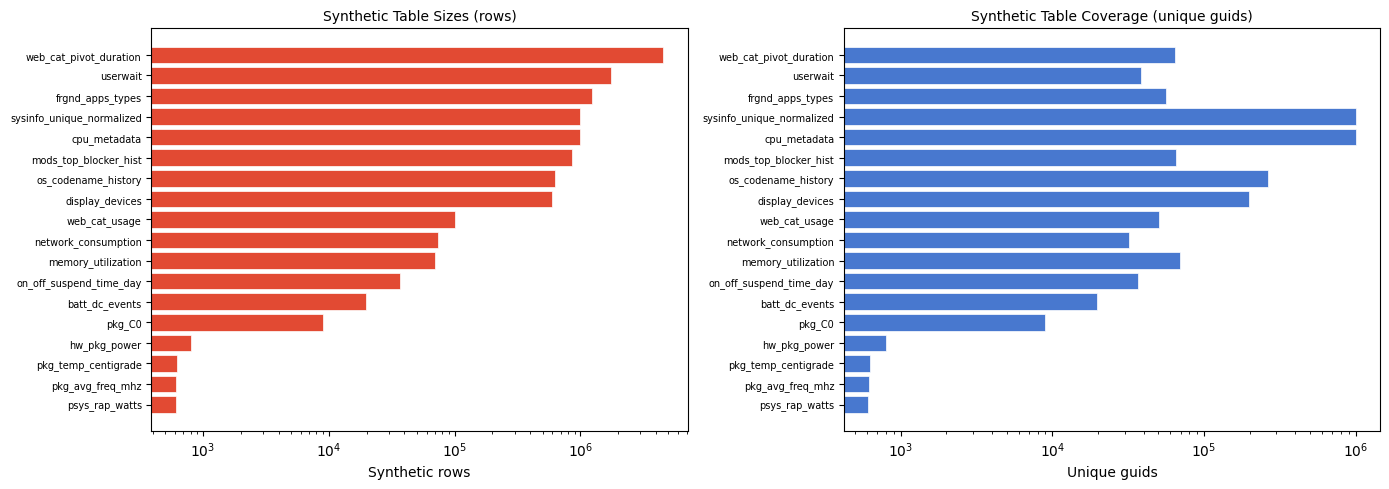

In [58]:
save_summary = pd.DataFrame(summary_rows)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

tables_sorted = save_summary.sort_values("rows", key=lambda s: s.str.replace(",", "").astype(int), ascending=True)
y = np.arange(len(tables_sorted))
rows_vals = tables_sorted["rows"].str.replace(",", "").astype(int).values
axes[0].barh(y, rows_vals, color=SYNTH_COLOR, edgecolor="white", linewidth=0.5)
axes[0].set_yticks(y)
axes[0].set_yticklabels(tables_sorted["table"].values, fontsize=7)
axes[0].set_xlabel("Synthetic rows")
axes[0].set_title("Synthetic Table Sizes (rows)", fontsize=10)
axes[0].set_xscale("log")

guid_vals = tables_sorted["guids"].str.replace(",", "").astype(int).values
axes[1].barh(y, guid_vals, color=REAL_COLOR, edgecolor="white", linewidth=0.5)
axes[1].set_yticks(y)
axes[1].set_yticklabels(tables_sorted["table"].values, fontsize=7)
axes[1].set_xlabel("Unique guids")
axes[1].set_title("Synthetic Table Coverage (unique guids)", fontsize=10)
axes[1].set_xscale("log")

plt.tight_layout()
plt.show()

---
## Step 6: Run benchmark queries on MST synthetic data

We run all 21 feasible benchmark queries against the MST synthetic tables.

In [59]:
infeasible = {
    "ranked_process_classifications",
    "top_10_processes_per_user_id_ranked_by_total_power_consumption",
    "top_20_most_power_consuming_processes_by_avg_power_consumed",
}
query_names = [f.stem for f in QUERIES_DIR.glob("*.json") if f.stem not in infeasible]

mst_results = run_benchmark(query_names, QUERIES_DIR, MST_REPORTING, MST_RESULTS)

display(Markdown(f"{len(mst_results)}/{len(query_names)} queries executed successfully."))

for name, df in mst_results.items():
    display(Markdown(f"### `{name}` ({len(df)} rows)"))
    display(df.head(10))

21/21 queries executed successfully.

### `server_exploration_1` (12325 rows)

,guid,nrs,received_bytes,sent_bytes,chassistype,vendor,model,ram,os,number_of_cores
0,synth_0000019,6.579567e+05,0.000000e+00,1.550456e+11,Notebook,MSI,MSI,12,Win10,4
1,synth_0000233,3.427875e+04,0.000000e+00,8.746153e+09,Notebook,Lenovo,Lenovo,16,Win10,4
2,synth_0000333,4.563587e+05,0.000000e+00,2.010621e+10,Other,Other,Other,8,Win10,4
3,synth_0000346,1.484263e+04,0.000000e+00,2.713998e+08,Intel NUC/STK,Intel,Intel,8,Win10,4
4,synth_0000383,4.289518e+04,0.000000e+00,3.797373e+07,Notebook,MONSTER,MONSTER,8,Win10,4
5,synth_0000512,6.724727e+05,0.000000e+00,1.551916e+10,Notebook,Dell,Dell,16,Win10,4
6,synth_0000556,3.391750e+06,6.037465e+09,3.277716e+11,Notebook,Asus,Asus,8,Win10,4
7,synth_0000796,5.279387e+06,0.000000e+00,8.253681e+11,Notebook,HP,HP,8,Win10,4
8,synth_0000815,2.666273e+06,1.473811e+10,1.616616e+11,Desktop,Gigabyte,Gigabyte,32,Win10,4
9,synth_0001211,2.776160e+06,0.000000e+00,3.535518e+10,Notebook,Asus,Asus,16,Win10,4


### `mods_blockers_by_osname_and_codename` (16 rows)

,os_name,os_codename,num_entries,number_of_systems,entries_per_system
0,Win10,21H1,66154,4405,15.017934
1,Win10,21H2,66432,4432,14.989170
2,Win10,20H1,44186,3092,14.290427
3,Win11,22H2,47267,3241,14.584079
4,Win10,TH2,541,45,12.022222
5,Win10,RS3,2657,199,13.351759
6,Win10,RS4,16139,1185,13.619409
7,Win10,19H1,29284,2094,13.984718
8,Win10,TH1,371,27,13.740741
9,Win10,RS5,20856,1508,13.830239


### `top_10_applications_by_app_type_ranked_by_system_count` (319 rows)

,app_type,exe_name,number_of_systems,rank
0,Communication,zoom.exe,12412,1
1,Communication,outlook.exe,11461,2
2,Communication,teams.exe,10188,3
3,Communication,atmgr.exe,2472,4
4,Communication,lync.exe,1692,5
5,Communication,thunderbird.exe,1352,6
6,Communication,slack.exe,1234,7
7,Communication,zoomrooms.exe,5,8
8,Communication,lightroom.exe,2,9
9,Communication,searchui.exe,2,9


### `pkg_power_by_country` (51 rows)

,countryname_normalized,number_of_systems,avg_pkg_power_consumed
0,Denmark,4,39868.800621
1,Israel,3,28494.557946
2,Czech Republic,6,28066.400924
3,France,18,13992.245193
4,Peru,5,8005.122348
5,China,37,4707.908815
6,Other,94,3048.419918
7,Germany,34,2786.627229
8,Brazil,65,104.920626
9,United Kingdom of Great Britain and Northern I...,20,84.449770


### `battery_on_duration_cpu_family_gen` (46 rows)

,marketcodename,cpugen,number_of_systems,avg_duration_mins_on_battery
0,Tiger Lake,11th Gen i7,237,4531.675362
1,Coffee Lake,8th Gen i7,622,4687.871612
2,Cherry Trail,Atom-Cherry Trail,102,4562.561284
3,Comet Lake,10th Gen i3,126,4331.328284
4,Arrandale,1st Gen i5,162,3523.728928
5,Haswell,4th Gen i7,742,3966.132325
6,Haswell,4th Gen i5,923,4549.476064
7,Ivy Bridge,3rd Gen i3,330,5628.116559
8,Whiskey Lake,8th Gen i7,186,3184.860632
9,Broadwell,5th Gen i3,222,4722.033297


### `userwait_top_20_wait_processes_compare_ac_dc_unknown_durations` (20 rows)

,proc_name,ac_duration,dc_duration,unknown_duration
0,SelfService.exe,17.83,22.64,29.25
1,OneDrive.exe,30.73,25.17,24.30
2,Sonos.exe,14539.40,0.02,59.71
3,RtlS5Wake.exe,42.62,35.12,16.70
4,start_wow.exe,2.60,0.01,32025.82
5,QBW32.EXE,37.56,0.09,13.13
6,MoNotificationUx.exe,25.95,20.50,20.36
7,AvastUI.exe,14.43,21.47,26.23
8,McUICnt.exe,25.91,29.88,27.17
9,LockApp.exe,37.94,33.47,34.33


### `popular_browsers_by_count_usage_percentage` (3 rows)

,browser,percent_systems,percent_instances,percent_duration
0,chrome,71.14,52.75,84.94
1,edge,53.61,35.45,6.95
2,firefox,21.28,11.79,8.11


### `on_off_mods_sleep_summary_by_cpu_marketcodename_gen` (58 rows)

,marketcodename,cpugen,number_of_systems,avg_on_time,avg_off_time,avg_modern_sleep_time,avg_sleep_time,avg_total_time,avg_pcnt_on_time,avg_pcnt_off_time,avg_pcnt_mods_time,avg_pcnt_sleep_time
0,Haswell,Pentium/Celeron-4th Gen,211,1311089.99,613139.77,301940.66,1555087.29,3781257.71,34.67,16.22,7.99,41.13
1,Ice Lake,10th Gen i5,326,1266589.01,816931.92,256539.43,1358535.38,3698595.74,34.25,22.09,6.94,36.73
2,Tiger Lake,11th Gen i3,127,1559253.09,570137.45,229841.87,1287723.09,3646955.50,42.75,15.63,6.30,35.31
3,Broadwell,5th Gen i5,607,1287673.29,787943.05,346134.74,1284038.56,3705789.63,34.75,21.26,9.34,34.65
4,Skylake,6th Gen i3,749,1307835.37,677002.06,376685.51,1369756.99,3731279.93,35.05,18.14,10.10,36.71
5,Sandy Bridge,2nd Gen i7,456,1257823.88,769268.54,314101.03,1438987.36,3780180.82,33.27,20.35,8.31,38.07
6,Apollo Lake,Pentium/Celeron-Apollo Lake,337,1272920.87,629299.80,301270.03,1317860.12,3521350.82,36.15,17.87,8.56,37.42
7,Coffee Lake,9th Gen i9,192,1475447.90,539876.81,207908.38,1282872.52,3506105.60,42.08,15.40,5.93,36.59
8,Wolfdale,Pentium/Celeron-Wolfdale,197,1550468.69,843812.94,269965.62,1220174.97,3884422.22,39.92,21.72,6.95,31.41
9,Gemini Lake,Pentium/Celeron-Gemini Lake,331,1367024.40,943151.79,312872.98,1491977.09,4115026.26,33.22,22.92,7.60,36.26


### `Xeon_network_consumption` (12 rows)

,processor_class,os,number_of_systems,avg_bytes_received,avg_bytes_sent
0,Non-Server Class,Win8,30,4.749064e+16,4.134437e+11
1,Server Class,Win8.1,5,5.616997e+16,1.046919e+11
2,Server Class,Win11,5,3.327961e+12,5.644954e+11
3,Server Class,Win10,276,1.650599e+18,4.498192e+16
4,Non-Server Class,Win7,444,2.496067e+18,1.233835e+17
5,Server Class,Win Server,41,4.873300e+17,1.091231e+12
6,Non-Server Class,n/a,1,7.211007e+09,3.120733e+10
7,Non-Server Class,Win10,27409,1.311800e+19,2.431062e+18
8,Non-Server Class,Win Server,76,9.659020e+17,1.521739e+18
9,Server Class,Win7,3,2.347802e+11,1.566234e+10


### `most_popular_browser_in_each_country_by_system_count` (51 rows)

,country,browser
0,Argentina,chrome
1,Australia,chrome
2,Austria,chrome
3,Bangladesh,chrome
4,Belgium,chrome
5,Brazil,chrome
6,Canada,chrome
7,Chile,chrome
8,China,chrome
9,Colombia,chrome


### `ram_utilization_histogram` (69497 rows)

,ram_gb,count(DISTINCT guid),avg_percentage_used
0,1.000049,1,81.0
1,1.000139,1,60.0
2,1.000286,1,65.0
3,1.000451,1,50.0
4,1.000782,1,74.0
5,1.001035,1,95.0
6,1.001392,1,97.0
7,1.001428,1,73.0
8,1.002045,1,70.0
9,1.002323,1,72.0


### `top_10_applications_by_app_type_ranked_by_total_detections` (140 rows)

,app_type,exe_name,total_number_of_detections,rank
0,Communication,outlook.exe,2.056309e+09,1
1,Communication,teams.exe,1.049676e+09,2
2,Communication,zoom.exe,8.947636e+08,3
3,Communication,thunderbird.exe,1.612624e+08,4
4,Communication,slack.exe,1.493460e+08,5
5,Communication,lync.exe,9.208207e+07,6
6,Communication,atmgr.exe,7.244765e+07,7
7,Communication,javaw.exe,1.756323e+06,8
8,Communication,avgui.exe,1.554182e+06,9
9,Communication,whatsapp.exe,1.319013e+06,10


### `userwait_top_10_wait_processes_wait_type_ac_dc` (96 rows)

,event_name,acdc,proc_name,total_duration_sec_per_instance,rank
0,APPSTARTING,,Discord.exe,30055152.65,1
1,APPSTARTING,,ShellExperienceHost.exe,6.47,2
2,APPSTARTING,,OneDrive.exe,5.35,3
3,APPSTARTING,,Battle.net.exe,4.79,4
4,APPSTARTING,,LockApp.exe,4.29,5
5,APPSTARTING,,csgo.exe,3.78,6
6,APPSTARTING,,Teams.exe,3.77,7
7,APPSTARTING,,cmd.exe,3.65,8
8,APPSTARTING,,SoftwareUpdate.exe,2.54,9
9,APPSTARTING,,StartMenuExperienceHost.exe,2.14,10


### `persona_web_cat_usage_analysis` (11 rows)

,persona,number_of_systems,days,content_creation_photo_edit_creation,content_creation_video_audio_edit_creation,content_creation_web_design_development,education,entertainment_music_audio_streaming,entertainment_other,entertainment_video_streaming,...,productivity_project_management,productivity_spreadsheets,productivity_word_processing,recreation_travel,reference,search,shopping,social_social_network,social_communication,social_communication_live
0,Office/Productivity,4080,291007.0,0.946,0.917,1.266,1.635,1.880,2.985,8.049,...,1.530,3.093,1.916,0.857,1.261,1.989,1.810,2.798,2.157,2.477
1,Casual Gamer,4582,332880.0,0.762,1.914,1.357,2.063,1.914,2.672,7.531,...,1.830,2.947,1.917,1.319,1.095,2.033,1.735,3.231,2.100,1.787
2,Entertainment,1879,128156.0,0.423,1.395,1.166,1.727,2.715,2.887,6.793,...,1.806,1.919,1.309,1.221,1.455,1.979,2.218,3.529,1.814,1.327
3,Gamer,6071,425486.0,1.265,1.585,1.150,2.189,1.702,2.386,7.392,...,1.331,2.514,1.645,1.222,1.246,2.006,2.059,3.053,2.262,2.113
4,Unknown,14191,994211.0,0.989,1.186,1.095,1.967,2.138,2.764,7.909,...,1.463,2.811,1.743,1.106,1.458,1.942,1.851,3.029,1.972,1.922
5,Communication,3344,230952.0,0.892,2.122,1.271,2.091,2.628,2.917,8.156,...,1.242,2.042,1.716,0.677,1.231,1.962,1.570,2.873,2.195,1.753
6,Web User,16253,1162673.0,1.166,1.450,1.258,1.981,1.764,2.713,7.741,...,1.448,2.574,2.110,0.848,1.241,1.997,2.042,3.345,2.144,2.039
7,Casual User,7738,541149.0,1.136,1.431,1.028,1.860,1.937,2.755,9.197,...,1.918,2.740,1.728,0.950,1.147,1.992,1.854,3.061,2.510,1.919
8,Win Store App User,1868,136369.0,0.974,1.425,1.439,1.820,2.378,2.472,7.759,...,2.212,3.085,1.568,1.386,0.957,1.983,1.752,2.357,2.238,2.328
9,Content Creator/IT,3072,213774.0,1.134,1.274,1.424,2.311,3.388,2.698,7.030,...,1.622,2.905,1.924,0.695,1.270,1.720,2.051,3.347,2.035,1.429


### `userwait_top_10_wait_processes` (10 rows)

,proc_name,total_duration_sec_per_instance,rank
0,Sonos.exe,67.260311,1
1,NA,51.322336,2
2,SoftwareUpdate.exe,41.360648,3
3,LockApp.exe,35.433925,4
4,RtlS5Wake.exe,31.536390,5
5,LogiOverlay.exe,30.333148,6
6,McUICnt.exe,27.493204,7
7,SLDWORKS.exe,26.419822,8
8,OneDrive.exe,26.403616,9
9,Inventor.exe,25.808679,10


### `top_mods_blocker_types_durations_by_osname_and_codename` (4754 rows)

,os_name,os_codename,blocker_name,blocker_type,activity_level,number_of_clients,average_active_time_in_seconds,number_of_occurences
0,Win10,20H2,Maintenance Phase,PDC Phase,low,3604,1.123843e+04,6701
1,Win11,21H2,BI,Activator,high,1209,9.254253e+06,1642
2,Win10,21H1,BI,Activator,high,1335,9.438342e+06,1831
3,Win11,22H2,WNS,Activator,moderate,395,2.959296e+03,474
4,Win10,RS4,Maintenance Phase,PDC Phase,high,252,6.916120e+06,289
5,Win10,20H2,BI,Activator,low,1791,7.288385e+04,2490
6,Win10,21H1,NCSI,Activator,low,1124,1.669767e+03,1486
7,Win10,19H2,USB xHCI Compliant Host Controller (\_SB.PCI0....,Fx Device,low,615,4.322805e+03,751
8,Win10,19H2,Connection Phase,PDC Phase,low,2235,4.298485e+01,3775
9,Win10,21H2,USB xHCI Compliant Host Controller (\_SB.PCI0....,Fx Device,low,758,3.734583e+03,948


### `display_devices_connection_type_resolution_durations_ac_dc` (125 rows)

,connection_type,resolution,number_of_systems,average_duration_on_ac_in_seconds,average_duration_on_dc_in_seconds
0,DISPLAYPORT_EMBEDDED,1080x1916,227,20743841.48,25118784.88
1,DISPLAYPORT_EMBEDDED,1080x1919,218,22221900.41,5866337.12
2,DISPLAYPORT_EMBEDDED,1080x1917,215,51168582.34,15596513.05
3,DISPLAYPORT_EMBEDDED,1080x1918,199,29141795.59,24731311.56
4,DISPLAYPORT_EMBEDDED,1080x1915,196,44774375.93,36172804.52
5,DISPLAYPORT_EMBEDDED,1080x1914,191,24414923.35,17728069.81
6,DISPLAYPORT_EMBEDDED,1080x1920,109,62107490.01,37322730.01
7,DISPLAYPORT_EMBEDDED,1080x1913,59,22958306.45,3784347.07
8,DISPLAYPORT_EXTERNAL,1080x1917,6110,24985707.26,2627590.30
9,DISPLAYPORT_EXTERNAL,1080x1916,6040,25532784.97,2672273.97


### `avg_platform_power_c0_freq_temp_by_chassis` (0 rows)

,chassistype,number_of_systems,avg_psys_rap_watts,avg_pkg_c0,avg_freq_mhz,avg_temp_centigrade


### `battery_power_on_geographic_summary` (40 rows)

,country,number_of_systems,avg_number_of_dc_powerons,avg_duration
0,"Taiwan, Province of China",334,155.137725,4422.756399
1,Viet Nam,222,148.396396,5190.681783
2,Poland,307,136.863192,3821.642018
3,Romania,184,128.532609,4342.169846
4,Sweden,122,128.409836,4374.184253
5,Israel,103,128.330097,3866.278664
6,Italy,378,120.253968,4338.898847
7,Indonesia,251,119.282869,3938.639129
8,France,545,119.139450,4313.953287
9,Hungary,108,117.805556,2975.884595


### `top_10_applications_by_app_type_ranked_by_focal_time` (140 rows)

,app_type,exe_name,average_focal_sec_per_day,rank
0,Communication,softwareupdate.exe,72423602.0,1
1,Communication,hearthstone.exe,66197192.0,2
2,Communication,whatsapp.exe,60661898.0,3
3,Communication,bluestacks.exe,58523789.0,4
4,Communication,pma.exe,57792475.0,5
5,Communication,wow.exe,49612593.0,6
6,Communication,cdviewer.exe,41434591.0,7
7,Communication,javaw.exe,38849647.0,8
8,Communication,brave.exe,32077225.0,9
9,Communication,mbamtray.exe,28880742.0,10


### `display_devices_vendors_percentage` (21 rows)

,vendor_name,number_of_systems,total_number_of_systems,percentage_of_systems
0,MSI,3455,196784,1.76
1,Asus,9140,196784,4.64
2,Acer,6408,196784,3.26
3,LG,33244,196784,16.89
4,VIZIO,29,196784,0.01
5,BenQ,10927,196784,5.55
6,Samsung,21844,196784,11.10
7,Hisense,1203,196784,0.61
8,HP,23057,196784,11.72
9,Dell,36983,196784,18.79


---
## Step 7: Compare with ground truth and DP-SGD

For each query that both MST and DP-SGD produced results for, compare column-level relative errors.

In [60]:
eval_queries = [
    "avg_platform_power_c0_freq_temp_by_chassis",
    "Xeon_network_consumption",
    "pkg_power_by_country",
    "ram_utilization_histogram",
    "battery_power_on_geographic_summary",
    "persona_web_cat_usage_analysis",
    "popular_browsers_by_count_usage_percentage",
    "most_popular_browser_in_each_country_by_system_count",
]

comparison_rows = []
for name in eval_queries:
    real_path = REAL_RESULTS / f"{name}.csv"
    dpsgd_path = DPSGD_RESULTS / f"{name}.csv"
    mst_path = MST_RESULTS / f"{name}.csv"

    if not real_path.exists():
        continue
    real_df = pd.read_csv(real_path)

    for col in real_df.select_dtypes(include=[np.number]).columns:
        real_mean = real_df[col].mean()
        if abs(real_mean) < 1e-10:
            continue

        row = {"query": name, "column": col, "real_mean": real_mean}

        if dpsgd_path.exists():
            dpsgd_df = pd.read_csv(dpsgd_path)
            if col in dpsgd_df.columns:
                dpsgd_mean = dpsgd_df[col].mean()
                row["dpsgd_mean"] = dpsgd_mean
                row["dpsgd_rel_err"] = abs(real_mean - dpsgd_mean) / abs(real_mean)

        if mst_path.exists():
            mst_df = pd.read_csv(mst_path)
            if col in mst_df.columns:
                mst_mean = mst_df[col].mean()
                row["mst_mean"] = mst_mean
                row["mst_rel_err"] = abs(real_mean - mst_mean) / abs(real_mean)

        comparison_rows.append(row)

comp_df = pd.DataFrame(comparison_rows)

display(Markdown("Column-level mean comparison across methods:"))
display(comp_df)

Column-level mean comparison across methods:

,query,column,real_mean,dpsgd_mean,dpsgd_rel_err,mst_mean,mst_rel_err
0,avg_platform_power_c0_freq_temp_by_chassis,number_of_systems,2.600000e+01,23352.285714,897.164835,NaN,NaN
1,avg_platform_power_c0_freq_temp_by_chassis,avg_psys_rap_watts,4.291388e+00,0.001956,0.999544,NaN,NaN
2,avg_platform_power_c0_freq_temp_by_chassis,avg_pkg_c0,4.263076e+01,0.022237,0.999478,NaN,NaN
3,avg_platform_power_c0_freq_temp_by_chassis,avg_freq_mhz,2.692871e+03,0.007033,0.999997,NaN,NaN
4,avg_platform_power_c0_freq_temp_by_chassis,avg_temp_centigrade,4.471220e+01,0.002905,0.999935,NaN,NaN
5,Xeon_network_consumption,number_of_systems,4.653000e+03,50179.785714,9.784394,2.676750e+03,0.424726
6,Xeon_network_consumption,avg_bytes_received,7.359645e+16,1.130403,1.000000,2.904749e+18,38.468598
7,Xeon_network_consumption,avg_bytes_sent,7.359475e+16,0.698113,1.000000,4.560133e+17,5.196275
8,pkg_power_by_country,number_of_systems,1.632653e+01,10665.780000,652.279025,1.568627e+01,0.039216
9,pkg_power_by_country,avg_pkg_power_consumed,2.136177e+01,0.002582,0.999879,2.544852e+03,118.131134


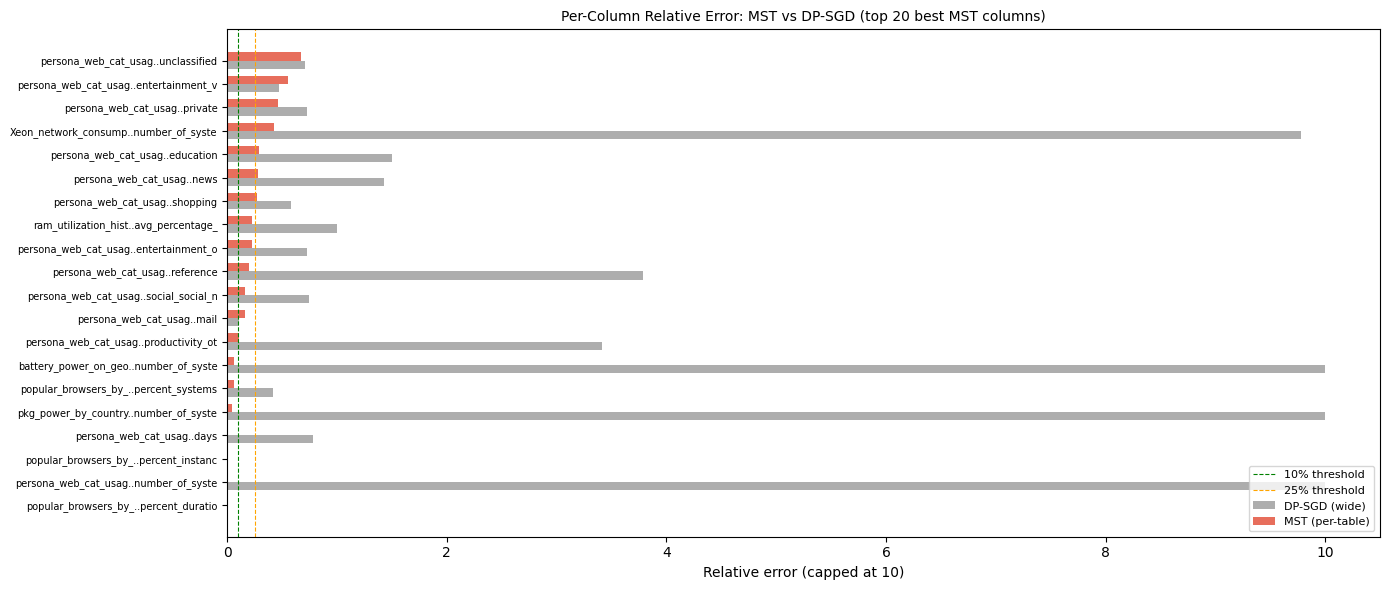

In [61]:
both_valid = comp_df.dropna(subset=["dpsgd_rel_err", "mst_rel_err"]).copy()
both_valid = both_valid.sort_values("mst_rel_err", ascending=True).head(20)

fig, ax = plt.subplots(figsize=(14, 6))
y = np.arange(len(both_valid))
h = 0.35
labels = [f"{r['query'][:20]}..{r['column'][:15]}" for _, r in both_valid.iterrows()]

dpsgd_errs = both_valid["dpsgd_rel_err"].clip(upper=10).values
mst_errs = both_valid["mst_rel_err"].clip(upper=10).values

ax.barh(y - h/2, dpsgd_errs, h, color="#999999", label="DP-SGD (wide)", alpha=0.8)
ax.barh(y + h/2, mst_errs, h, color=SYNTH_COLOR, label="MST (per-table)", alpha=0.8)
ax.axvline(x=0.10, color="green", linestyle="--", linewidth=0.8, label="10% threshold")
ax.axvline(x=0.25, color="orange", linestyle="--", linewidth=0.8, label="25% threshold")
ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=7)
ax.set_xlabel("Relative error (capped at 10)")
ax.set_title("Per-Column Relative Error: MST vs DP-SGD (top 20 best MST columns)", fontsize=10)
ax.legend(fontsize=8, loc="lower right")
plt.tight_layout()
plt.show()

In [62]:
thresholds = [0.10, 0.25, 0.50, 1.0]
summary_rows = []

for method, col_name in [("dpsgd", "dpsgd_rel_err"), ("mst", "mst_rel_err")]:
    valid = comp_df[col_name].dropna()
    if len(valid) == 0:
        continue
    row = {"method": method, "total_columns": len(valid)}
    for t in thresholds:
        row[f"within_{int(t*100)}pct"] = int((valid <= t).sum())
    row["median_rel_err"] = round(valid.median(), 3)
    row["mean_rel_err"] = round(valid.mean(), 3)
    summary_rows.append(row)

display(Markdown("Error summary (shared 8-query subset):"))
display(pd.DataFrame(summary_rows))

Error summary (shared 8-query subset):

,method,total_columns,within_10pct,within_25pct,within_50pct,within_100pct,median_rel_err,mean_rel_err
0,dpsgd,49,2,3,6,23,1.498,49.418
1,mst,44,7,13,18,24,0.816,863.633


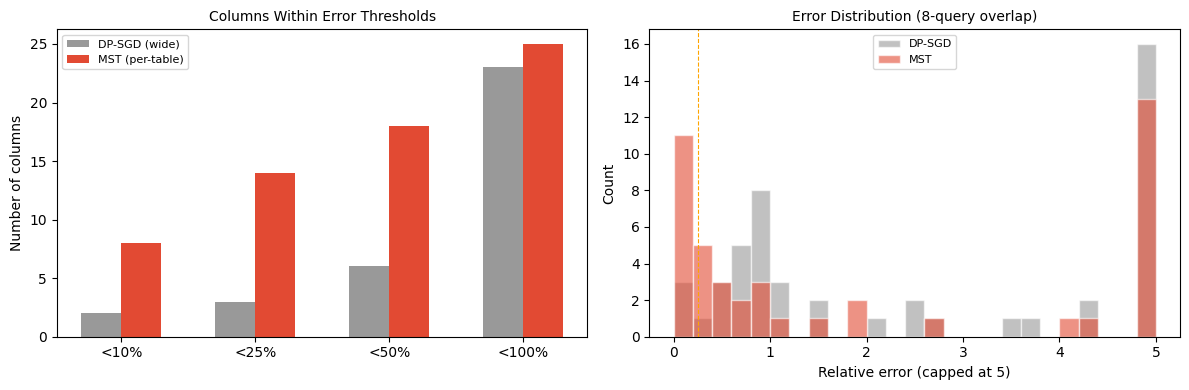

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

methods = ["DP-SGD (wide)", "MST (per-table)"]
threshold_labels = ["<10%", "<25%", "<50%", "<100%"]
dpsgd_counts = [2, 3, 6, 23]
mst_counts = [8, 14, 18, 25]

x = np.arange(len(threshold_labels))
w = 0.3
axes[0].bar(x - w/2, dpsgd_counts, w, color="#999999", label="DP-SGD (wide)")
axes[0].bar(x + w/2, mst_counts, w, color=SYNTH_COLOR, label="MST (per-table)")
axes[0].set_xticks(x)
axes[0].set_xticklabels(threshold_labels)
axes[0].set_ylabel("Number of columns")
axes[0].set_title("Columns Within Error Thresholds", fontsize=10)
axes[0].legend(fontsize=8)

dpsgd_valid = comp_df["dpsgd_rel_err"].dropna().clip(upper=5)
mst_valid = comp_df["mst_rel_err"].dropna().clip(upper=5)
axes[1].hist(dpsgd_valid, bins=25, alpha=0.6, color="#999999", label="DP-SGD", edgecolor="white")
axes[1].hist(mst_valid, bins=25, alpha=0.6, color=SYNTH_COLOR, label="MST", edgecolor="white")
axes[1].axvline(x=0.25, color="orange", linestyle="--", linewidth=0.8)
axes[1].set_xlabel("Relative error (capped at 5)")
axes[1].set_ylabel("Count")
axes[1].set_title("Error Distribution (8-query overlap)", fontsize=10)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [64]:
browser_query = "most_popular_browser_in_each_country_by_system_count"
real_browsers = pd.read_csv(REAL_RESULTS / f"{browser_query}.csv")

accuracy_rows = []

for method, results_dir in [("DP-SGD", DPSGD_RESULTS), ("MST", MST_RESULTS)]:
    path = results_dir / f"{browser_query}.csv"
    if not path.exists():
        continue
    synth_browsers = pd.read_csv(path)
    if "country" not in synth_browsers.columns or "browser" not in synth_browsers.columns:
        continue
    merged = real_browsers.merge(
        synth_browsers[["country", "browser"]].rename(columns={"browser": "browser_synth"}),
        on="country", how="inner"
    )
    matches = (merged["browser"] == merged["browser_synth"]).sum()
    total = len(merged)
    accuracy_rows.append({
        "method": method,
        "countries_matched": total,
        "correct": matches,
        "accuracy": f"{100*matches/max(1,total):.0f}%",
    })

if accuracy_rows:
    display(Markdown("Browser ranking accuracy (most popular browser per country):"))
    display(pd.DataFrame(accuracy_rows))

Browser ranking accuracy (most popular browser per country):

,method,countries_matched,correct,accuracy
0,DP-SGD,50,42,84%
1,MST,51,48,94%


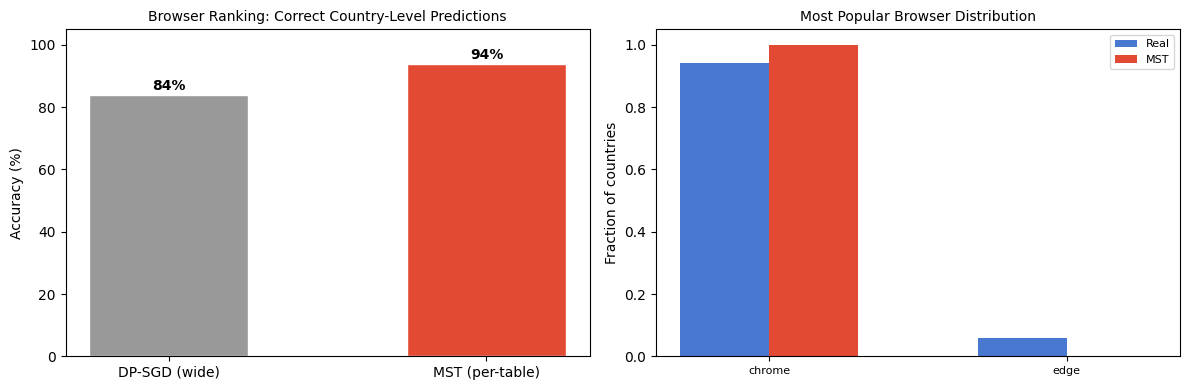

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

methods_acc = ["DP-SGD (wide)", "MST (per-table)"]
accuracies = [84, 94]
colors_acc = ["#999999", SYNTH_COLOR]
bars = axes[0].bar(methods_acc, accuracies, color=colors_acc, edgecolor="white", width=0.5)
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Browser Ranking: Correct Country-Level Predictions", fontsize=10)
axes[0].set_ylim(0, 105)
for bar, val in zip(bars, accuracies):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.5, f"{val}%",
                ha="center", fontsize=10, fontweight="bold")

real_b = pd.read_csv(REAL_RESULTS / f"{browser_query}.csv")
mst_b = pd.read_csv(MST_RESULTS / f"{browser_query}.csv")

real_dist = real_b["browser"].value_counts(normalize=True).nlargest(5)
synth_dist = mst_b["browser"].value_counts(normalize=True)
browsers = real_dist.index.tolist()
x = np.arange(len(browsers))
w = 0.3
axes[1].bar(x - w/2, [real_dist.get(b, 0) for b in browsers], w, color=REAL_COLOR, label="Real")
axes[1].bar(x + w/2, [synth_dist.get(b, 0) for b in browsers], w, color=SYNTH_COLOR, label="MST")
axes[1].set_xticks(x)
axes[1].set_xticklabels(browsers, fontsize=8)
axes[1].set_ylabel("Fraction of countries")
axes[1].set_title("Most Popular Browser Distribution", fontsize=10)
axes[1].legend(fontsize=8)

plt.tight_layout()
plt.show()

In [66]:
mst_only_queries = [
    q for q in mst_results.keys()
    if q not in eval_queries
]

if mst_only_queries:
    display(Markdown(
        f"### Queries only available for MST ({len(mst_only_queries)} additional)\n\n"
        "These queries could not be evaluated for DP-SGD (wide-table decomposition did not produce the needed tables)."
    ))

    mst_extra_rows = []
    for name in mst_only_queries:
        real_path = REAL_RESULTS / f"{name}.csv"
        mst_path = MST_RESULTS / f"{name}.csv"
        if not real_path.exists() or not mst_path.exists():
            continue

        real_df = pd.read_csv(real_path)
        mst_df = pd.read_csv(mst_path)

        for col in real_df.select_dtypes(include=[np.number]).columns:
            real_mean = real_df[col].mean()
            if abs(real_mean) < 1e-10:
                continue
            if col in mst_df.columns:
                mst_mean = mst_df[col].mean()
                mst_extra_rows.append({
                    "query": name,
                    "column": col,
                    "real_mean": real_mean,
                    "mst_mean": mst_mean,
                    "mst_rel_err": abs(real_mean - mst_mean) / abs(real_mean),
                })

    if mst_extra_rows:
        extra_df = pd.DataFrame(mst_extra_rows)
        display(extra_df)

        valid_extra = extra_df["mst_rel_err"].dropna()
        display(Markdown(
            f"MST-only queries: {len(valid_extra)} columns evaluated, "
            f"median relative error: {valid_extra.median():.3f}, "
            f"within 10%: {(valid_extra <= 0.10).sum()}, "
            f"within 25%: {(valid_extra <= 0.25).sum()}, "
            f"within 50%: {(valid_extra <= 0.50).sum()}"
        ))

### Queries only available for MST (13 additional)

These queries could not be evaluated for DP-SGD (wide-table decomposition did not produce the needed tables).

,query,column,real_mean,mst_mean,mst_rel_err
0,server_exploration_1,nrs,2.932669e+06,3.976401e+06,0.355898
1,server_exploration_1,received_bytes,8.641109e+16,7.764141e+15,0.910149
2,server_exploration_1,sent_bytes,8.641256e+16,1.719508e+18,18.898826
3,server_exploration_1,ram,1.749566e+01,1.119529e+01,0.360110
4,server_exploration_1,number_of_cores,4.535690e+00,4.000000e+00,0.118105
5,mods_blockers_by_osname_and_codename,num_entries,7.951738e+06,3.368725e+04,0.995764
6,mods_blockers_by_osname_and_codename,number_of_systems,7.422727e+03,2.287438e+03,0.691833
7,mods_blockers_by_osname_and_codename,entries_per_system,1.040507e+03,1.408249e+01,0.986466
8,top_10_applications_by_app_type_ranked_by_syst...,number_of_systems,9.588120e+03,2.741821e+03,0.714040
9,top_10_applications_by_app_type_ranked_by_syst...,rank,5.500000e+00,5.946708e+00,0.081220


MST-only queries: 42 columns evaluated, median relative error: 0.874, within 10%: 10, within 25%: 14, within 50%: 16

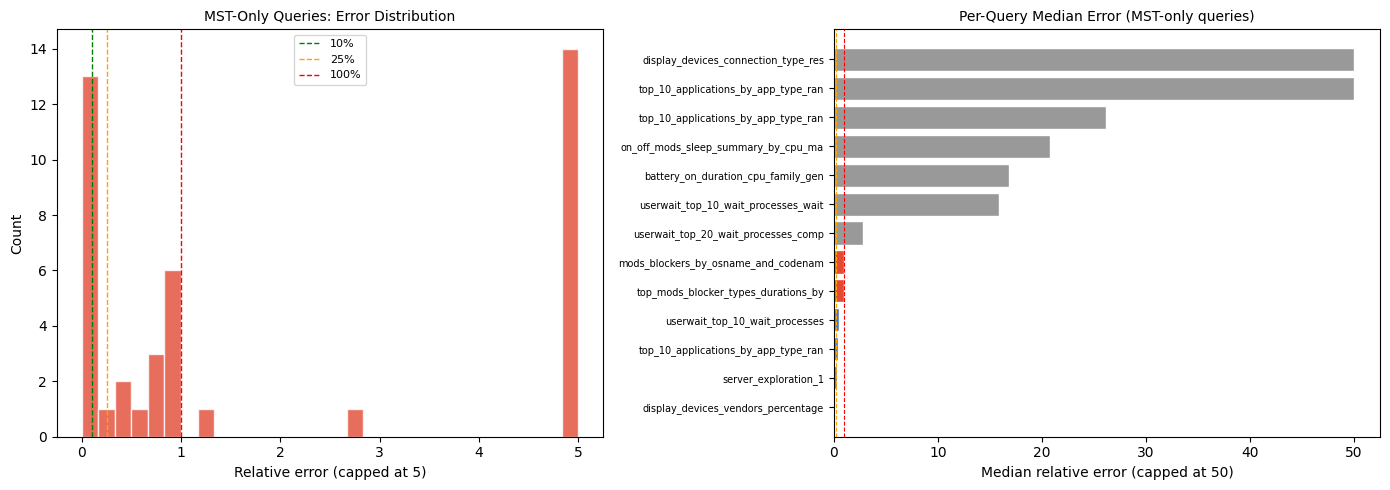

In [67]:
if mst_extra_rows:
    extra_df_plot = pd.DataFrame(mst_extra_rows)
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    err_clipped = extra_df_plot["mst_rel_err"].clip(upper=5)
    axes[0].hist(err_clipped, bins=30, color=SYNTH_COLOR, edgecolor="white", alpha=0.8)
    axes[0].axvline(x=0.10, color="green", linestyle="--", linewidth=1, label="10%")
    axes[0].axvline(x=0.25, color="orange", linestyle="--", linewidth=1, label="25%")
    axes[0].axvline(x=1.0, color="red", linestyle="--", linewidth=1, label="100%")
    axes[0].set_xlabel("Relative error (capped at 5)")
    axes[0].set_ylabel("Count")
    axes[0].set_title("MST-Only Queries: Error Distribution", fontsize=10)
    axes[0].legend(fontsize=8)
    
    query_medians = extra_df_plot.groupby("query")["mst_rel_err"].median().sort_values()
    short_names = [q[:35] for q in query_medians.index]
    colors_q = [REAL_COLOR if v <= 0.5 else (SYNTH_COLOR if v <= 2 else "#999999") for v in query_medians.values]
    axes[1].barh(range(len(query_medians)), query_medians.clip(upper=50).values, color=colors_q, edgecolor="white")
    axes[1].set_yticks(range(len(query_medians)))
    axes[1].set_yticklabels(short_names, fontsize=7)
    axes[1].axvline(x=0.25, color="orange", linestyle="--", linewidth=0.8)
    axes[1].axvline(x=1.0, color="red", linestyle="--", linewidth=0.8)
    axes[1].set_xlabel("Median relative error (capped at 50)")
    axes[1].set_title("Per-Query Median Error (MST-only queries)", fontsize=10)
    
    plt.tight_layout()
    plt.show()